In [35]:
import pandas as pd

pd.set_option('display.max_column',None)
pd.set_option('display.max_rows',None)
pd.set_option('display.max_seq_items',None)
pd.set_option('display.max_colwidth', 5000)

from IPython.display import display, Markdown, Latex

In [36]:
with open("data/softskills.txt") as file:
    softskills = [line.strip() for line in file.readlines()]

softskills_df = pd.DataFrame(softskills)
softskills_df

0
0                Teamwork
1              Leadership
2              Resilience
3  Emotional Intelligence
4           Communication
5             Proactivity
6                  Ethics
7        Complex Thinking

In [37]:
from data.operations_instances_ss_confirmed import fetch_operations_files, OperationFile

operations_files = fetch_operations_files()

In [38]:
from trigger.operation import read_operations

operations = read_operations(operations_files[0].full_path)

operations_df = pd.DataFrame([ { "type": operation.type, "info": operation.info } for operation in operations])
operations_df

type  \
0                OperationType.ADD   
1                OperationType.ADD   
2                OperationType.ADD   
3                OperationType.ADD   
4                OperationType.ADD   
5                OperationType.ADD   
6                OperationType.ADD   
7  OperationType.EVALUATE_CLUSTERS   
8   OperationType.EVALUATE_MATCHES   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                info  
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         AddInfo(tag='1', value=Instance(value=Opening(entityId='1', hardSkills=[Hardskill(name='Corporate Publications Corporate Relations')], softSkills=[Softskill(name='Leadership'), Softskill(name='Communication'), Softskill(name='Emotional Intelligence')])), transformer_key='identity')  
1                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 AddInfo(tag='3', value=Instance(value=Opening(entityId='3', hardSkills=[Hardskill(name='Feasibility Studies Field Studies'), Hardskill(name='Lab Management'), Hardskill(name='RandD Management Simulation Dev.'), Hardskill(name='Patent Application'), Hardskil

In [39]:
from trigger.test.trigger_test_runner import TriggerTestRunner

In [40]:
from interference.clusters.ecm import ECM


def with_ecm(operations_file: OperationFile):

    param_grid = {
        "distance_threshold": [0.001, 0.01, 0.1, 0.3, 0.5,
                               0.7, 0.9, 1, 1.2, 1.4, 1.5]
    }

    TriggerTestRunner(
        processor_class=ECM,
        param_grid=param_grid,
        operations=read_operations(operations_file.full_path),
        output_base_folder=f"results/openings_users/operations/{operations_file.test_subpath}",
        skip_done=True
    ).run_tests()


In [41]:
from interference.clusters.gturbo import GTurbo


def with_gturbo(operations_file: OperationFile):

    param_grid = {
        "epsilon_b": [0.001, 0.01],
        "epsilon_n": [0],
        "lam": [200, 500],
        "beta": [0.9995],
        "alpha": [0.95],
        "max_age": [200, 500],
        "r0": [0.5, 1, 2.5, 5, 8]
    }

    if operations_file.layer.find("concat") != -1:
        param_grid["dimensions"] = [2048]
    else:
        param_grid["dimensions"] = [1024]

    TriggerTestRunner(
        processor_class=GTurbo,
        param_grid=param_grid,
        operations=read_operations(operations_file.full_path),
        output_base_folder=f"results/openings_users/operations/{operations_file.test_subpath}",
        skip_done=True
    ).run_tests()


In [42]:
from interference.clusters.fake import Fake


def with_fake(operations_file: OperationFile):

    param_grid = {
    }

    TriggerTestRunner(
        processor_class=Fake,
        param_grid=param_grid,
        operations=read_operations(operations_file.full_path),
        output_base_folder=f"results/openings_users/operations/{operations_file.test_subpath}",
        skip_done=True
    ).run_tests()


In [43]:
from interference.clusters.covariance import CovarianceCluster


def with_covariance(operations_file: OperationFile):

    param_grid = {
        "initial_std": [10],
    }

    if operations_file.layer.find("concat") != -1:
        param_grid["dimensions"] = [2048]
    else:
        param_grid["dimensions"] = [1024]

    TriggerTestRunner(
        processor_class=CovarianceCluster,
        param_grid=param_grid,
        operations=read_operations(operations_file.full_path),
        output_base_folder=f"results/openings_users/operations/{operations_file.test_subpath}",
        skip_done=True
    ).run_tests()


In [44]:
import logging
logging.getLogger("test_runner").setLevel(logging.WARNING)

for operations_file in operations_files:
    with_ecm(operations_file)
    with_gturbo(operations_file)
    with_covariance(operations_file)
    with_fake(operations_file)

In [45]:
from typing import List, Any, Tuple, Dict
import os
import json

OperationResults = Tuple[str, str, Dict[str, Any]]


def fetch_results(operation_file: "OperationFile", base_results_path: str = "results/openings_users/operations") -> List[OperationResults]:
    folder = os.path.join(base_results_path, operation_file.test_subpath)
    collected: List[OperationResults] = []

    for cluster_folder_name in os.listdir(folder):

        if cluster_folder_name in ["__pycache__", "__init__.py"]:
            continue

        cluster_folder_path = os.path.join(folder, cluster_folder_name)

        for result_name in os.listdir(cluster_folder_path):
            full_path = os.path.join(cluster_folder_path, result_name)

            with open(full_path, 'r') as file:
                json_results = json.load(file)

            collected.append((cluster_folder_name, full_path, json_results))

    return collected

In [46]:
def distribution_with_zeros(before: dict, fake_dict: dict) -> dict:
    for _value in fake_dict:
        if _value not in before:
            before[_value] = 0
        
    return before

def distribution_key_ordered(before: dict) -> dict:
    after = {}
    for _value in sorted(before):
        after[_value] = before[_value]
    return after

In [47]:
from pathlib import Path

operations_file_to_name_to_cluster_metrics: Dict[str, Dict[str, Dict[str, Any]]] = {}
operations_file_to_name_to_matches_metrics: Dict[str, Dict[str, Dict[str, Any]]] = {}

for operations_file in operations_files:
    results = fetch_results(operations_file)

    cluster_metrics = [("ss", -2., 1), ("cluster_score", 0., 1.)]
    
    matches_metrics = [
        "distribution #matches",
        "distribution #potential",
        "distribution #potential after similarity", 
        "distribution score range",
        "distribution matches score range",
        "distribution similarity score range",
        "distribution quality score range"
    ]

    name_to_cluster_metrics: Dict[str, Dict[str, Any]] = {}
    name_to_matches_metrics: Dict[str, Dict[str, Any]] = {}

    for clusterer, path, jsons in results:
        clusterer_description = Path(path).name.replace(".json", "")

        operation_results = jsons["results"]
        cluster_evaluation = operation_results[0]["Result"]

        continue_this_clusterer = True

        for cluster_metric, _min, _max in cluster_metrics:
            cluster_metric_score = cluster_evaluation[cluster_metric]

            if clusterer_description == "Fake":
                name_to_cluster_metrics.setdefault(clusterer_description, {})
                name_to_cluster_metrics["Fake"][cluster_metric] = cluster_metric_score

            elif _max > cluster_metric_score > _min:
                name_to_cluster_metrics.setdefault(clusterer_description, {})
                name_to_cluster_metrics[clusterer_description][cluster_metric] = cluster_metric_score

            else:
                name_to_cluster_metrics.pop(clusterer_description, None)
                continue_this_clusterer = False
                break

        if not continue_this_clusterer:
            continue

        matches_evaluation = operation_results[1]["Result"]

        for matches_metric in matches_metrics:
            name_to_matches_metrics.setdefault(clusterer_description, {})
            name_to_matches_metrics[clusterer_description][matches_metric] = matches_evaluation[matches_metric]


    for matches_metric in matches_metrics:
        if matches_metric.find("distribution") != -1:
            dict_with_everything = {}
        
            for name in name_to_matches_metrics:

                dict_with_everything = distribution_with_zeros(
                    dict_with_everything,
                    name_to_matches_metrics[name][matches_metric]
                )
            
            for name in name_to_matches_metrics:
                
                name_to_matches_metrics[name][matches_metric] = distribution_with_zeros(
                    name_to_matches_metrics[name][matches_metric],
                    dict_with_everything
                )

                name_to_matches_metrics[name][matches_metric] = distribution_key_ordered(name_to_matches_metrics[name][matches_metric])

    operations_file_to_name_to_cluster_metrics[operations_file.full_path] = name_to_cluster_metrics
    operations_file_to_name_to_matches_metrics[operations_file.full_path] = name_to_matches_metrics


In [48]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

## OperationFile(layer='concat_norm', test_subpath='1/concat_norm', full_path='data/operations_instances_ss_confirmed/1/concat_norm') - cluster metrics

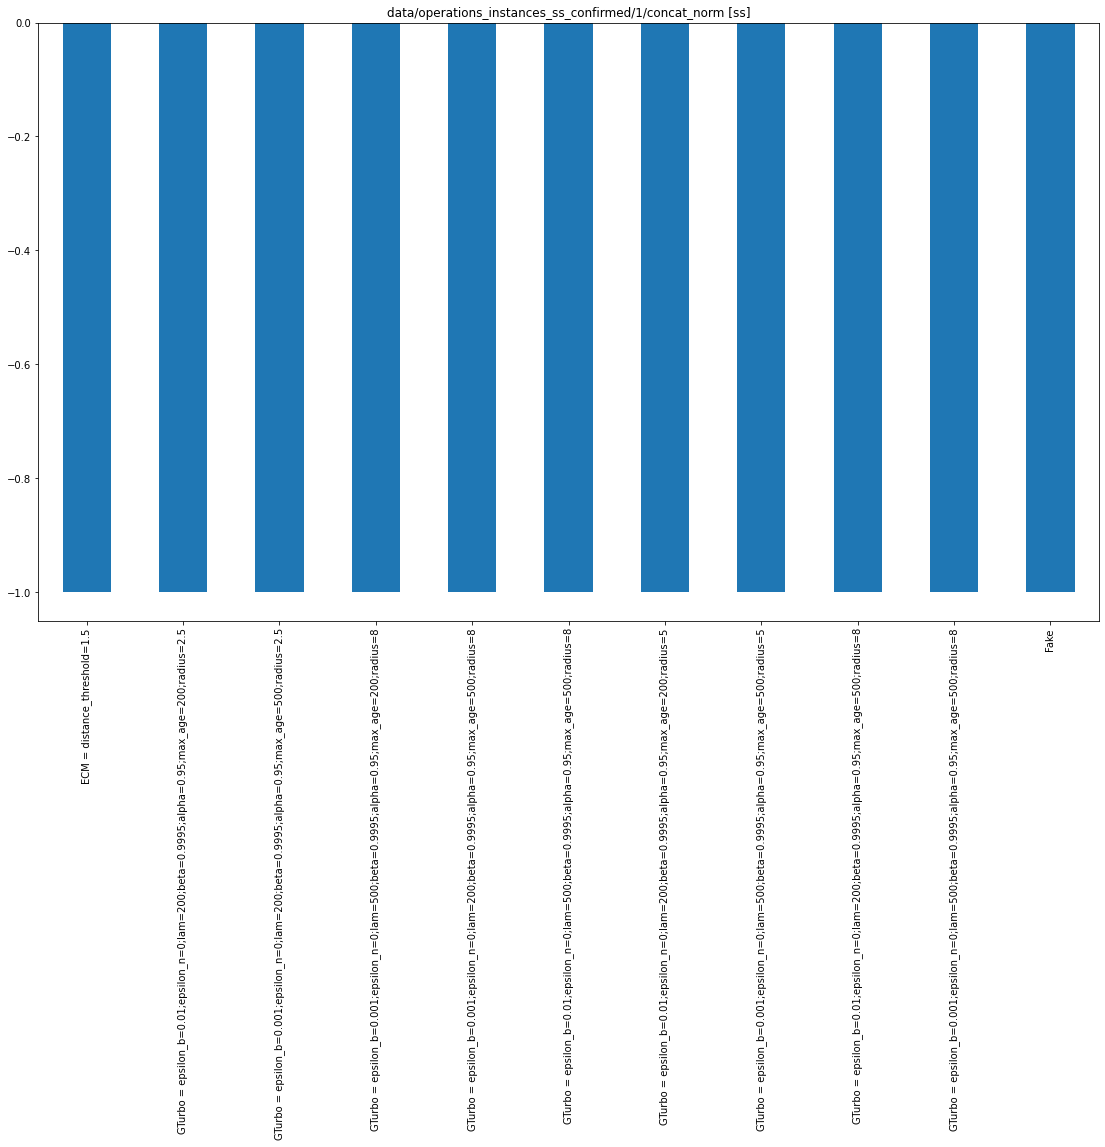

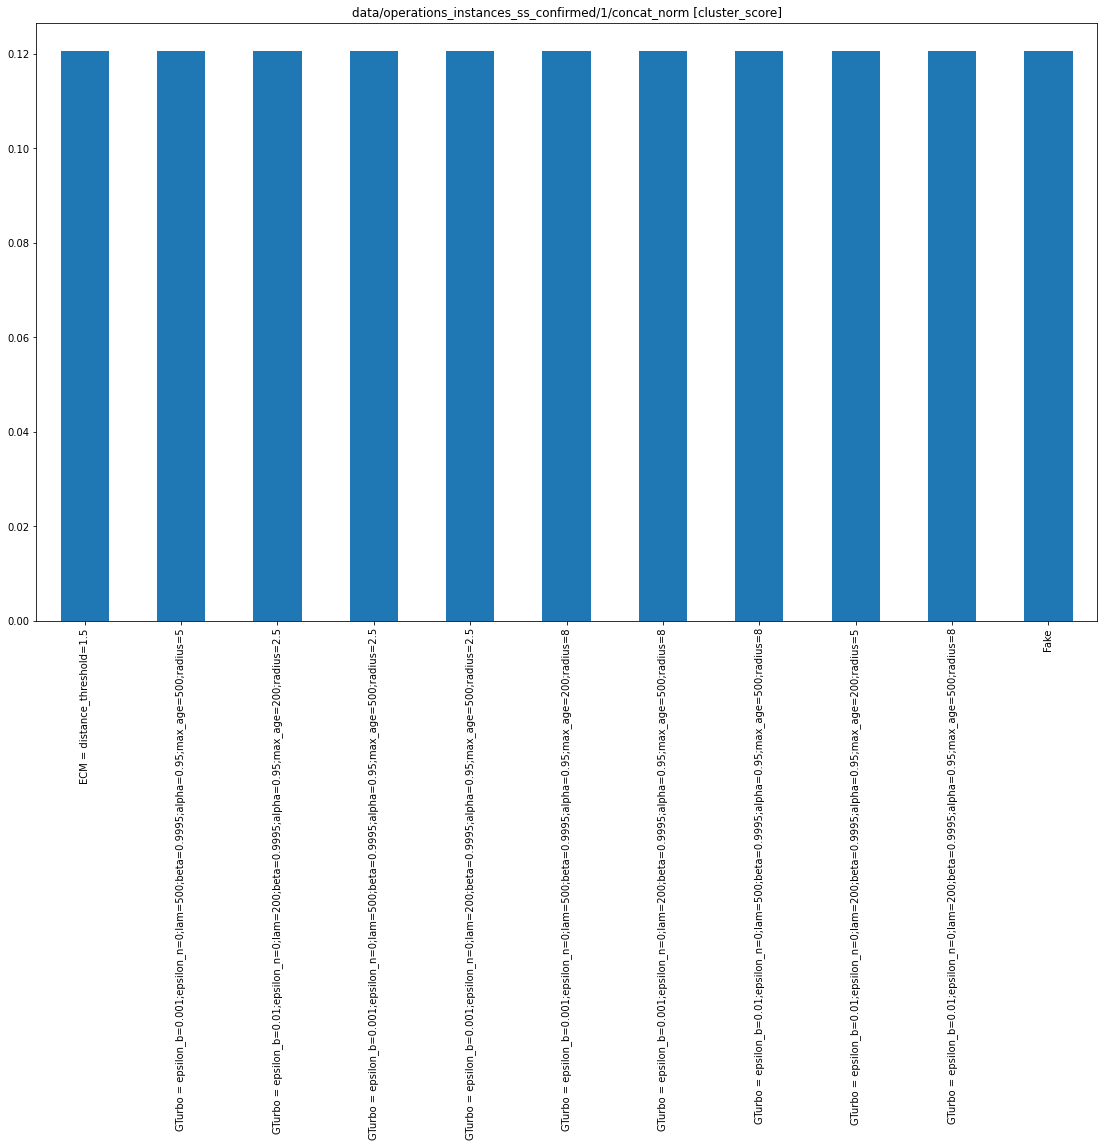

## OperationFile(layer='concat', test_subpath='1/concat', full_path='data/operations_instances_ss_confirmed/1/concat') - cluster metrics

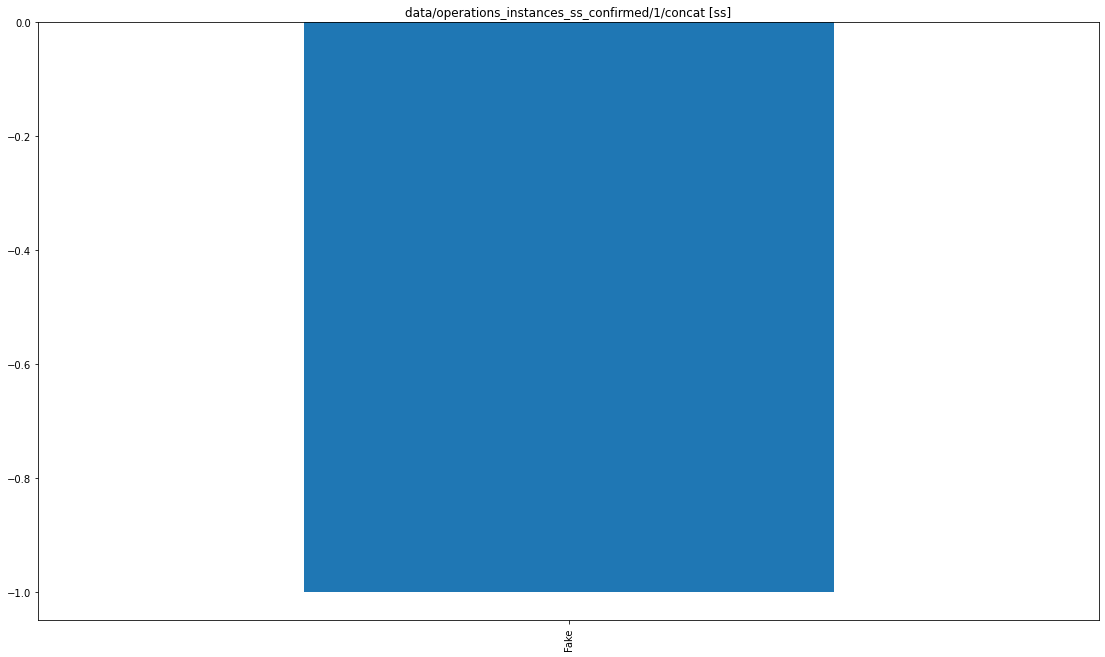

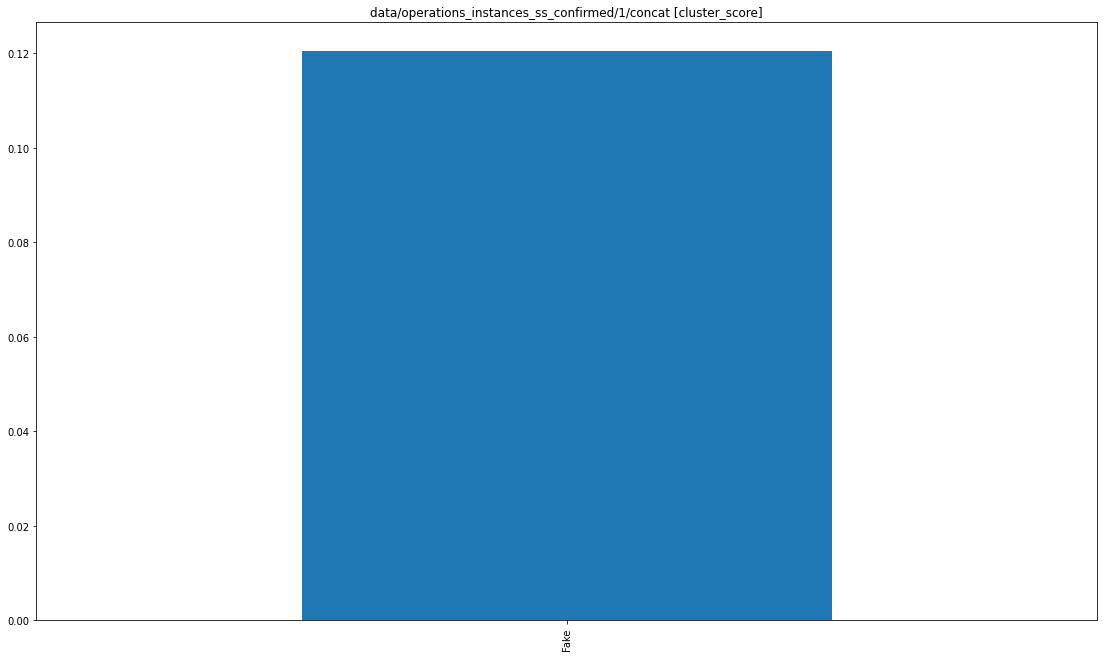

## OperationFile(layer='avg', test_subpath='1/avg', full_path='data/operations_instances_ss_confirmed/1/avg') - cluster metrics

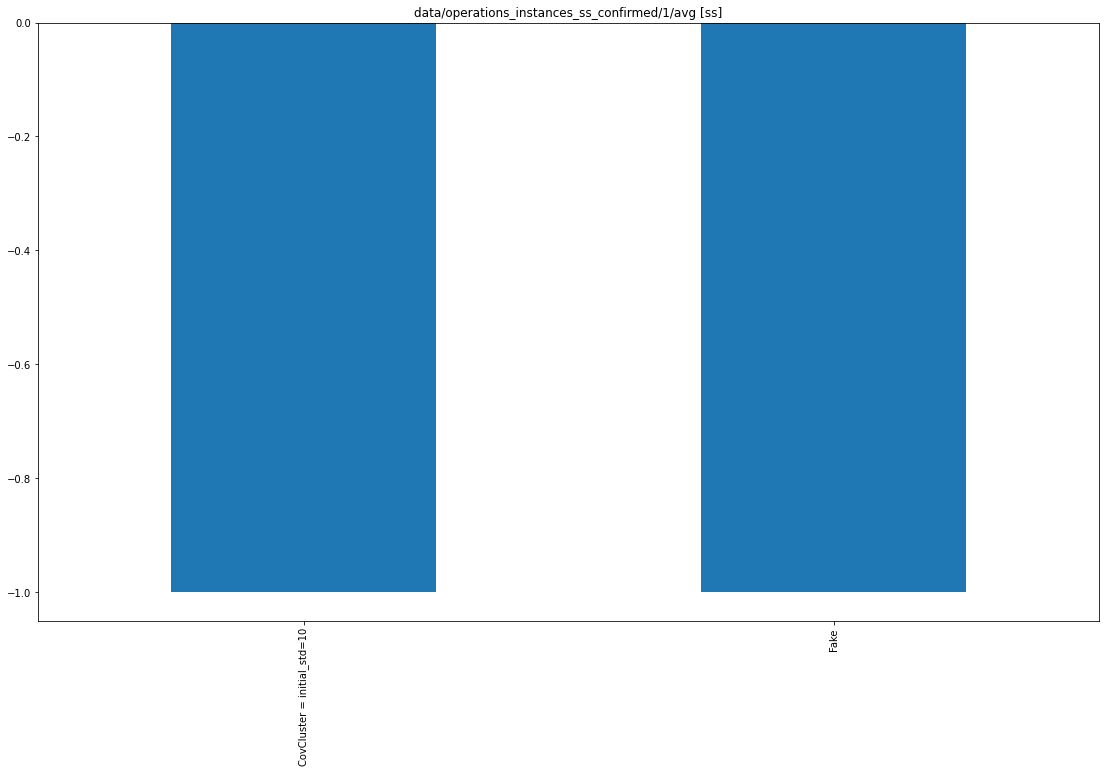

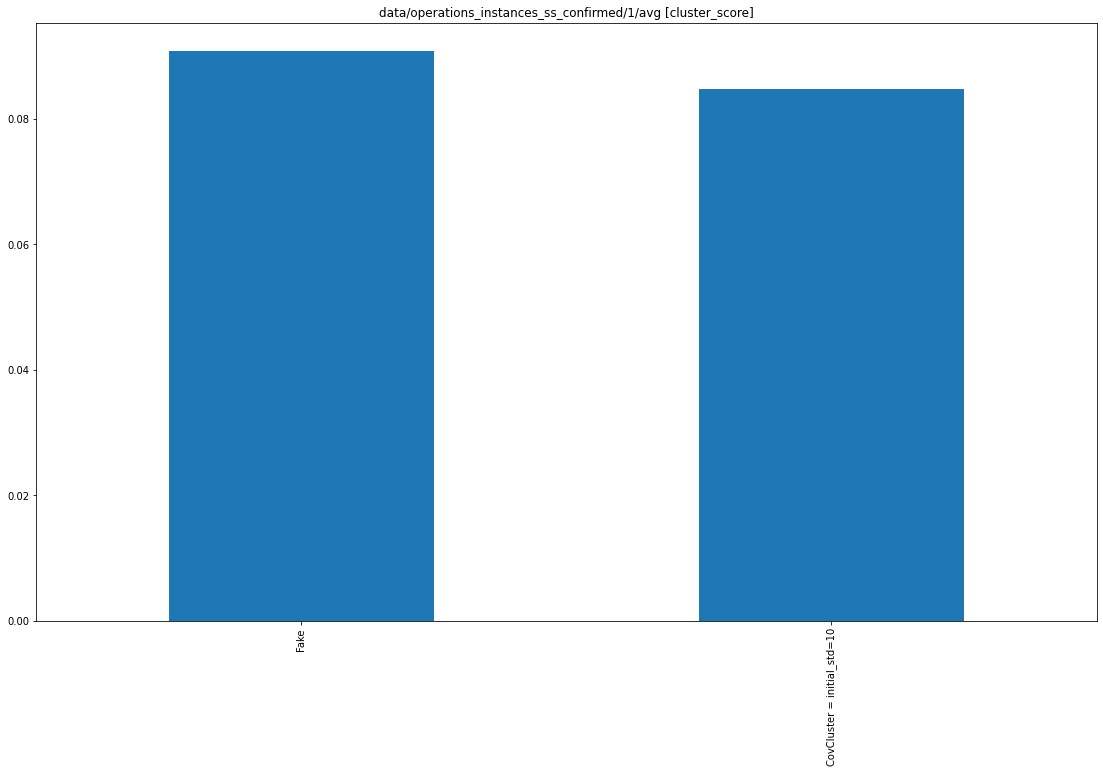

## OperationFile(layer='avg_norm', test_subpath='1/avg_norm', full_path='data/operations_instances_ss_confirmed/1/avg_norm') - cluster metrics

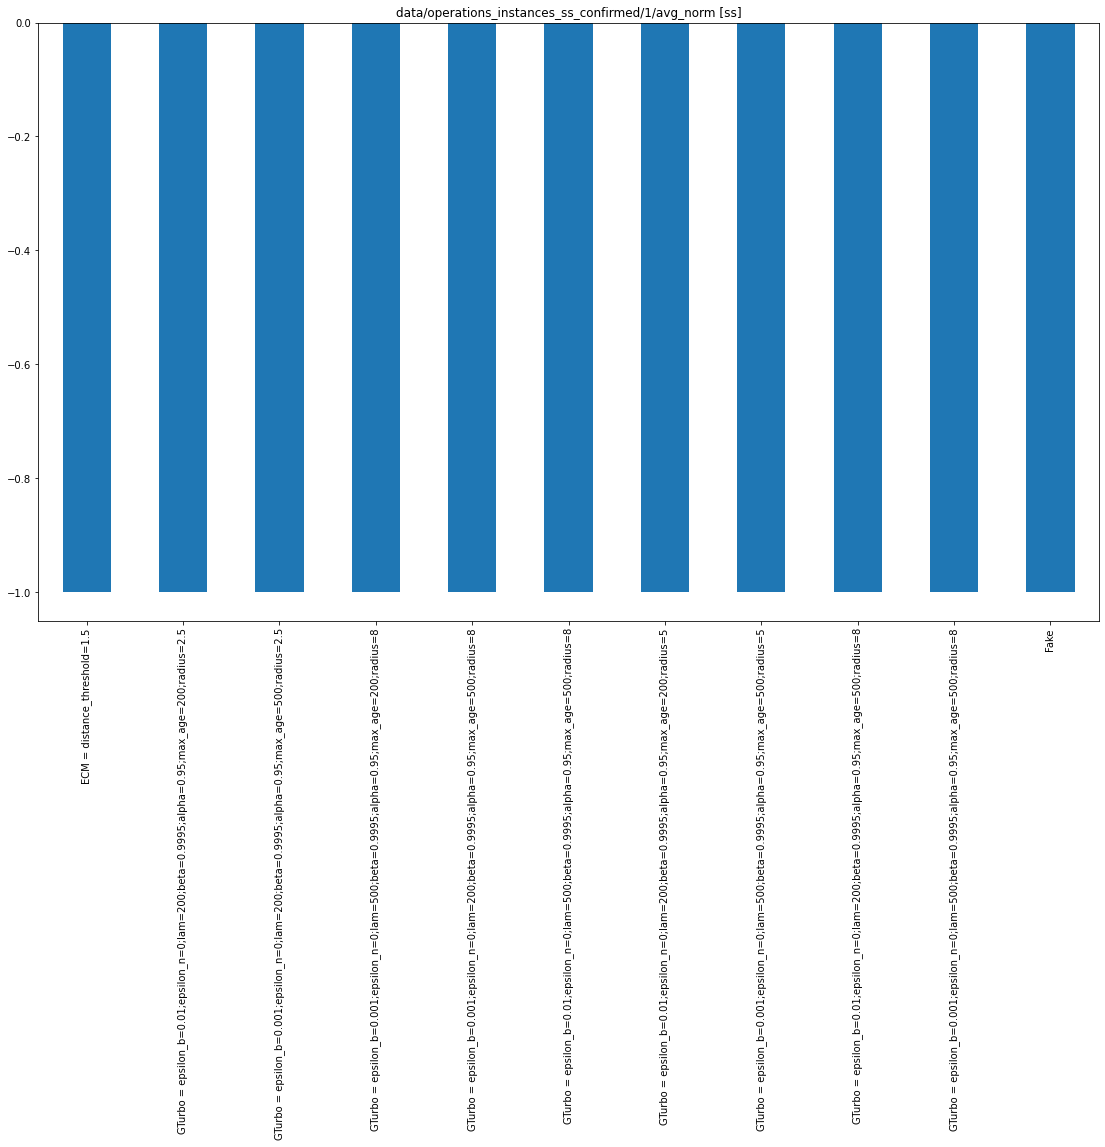

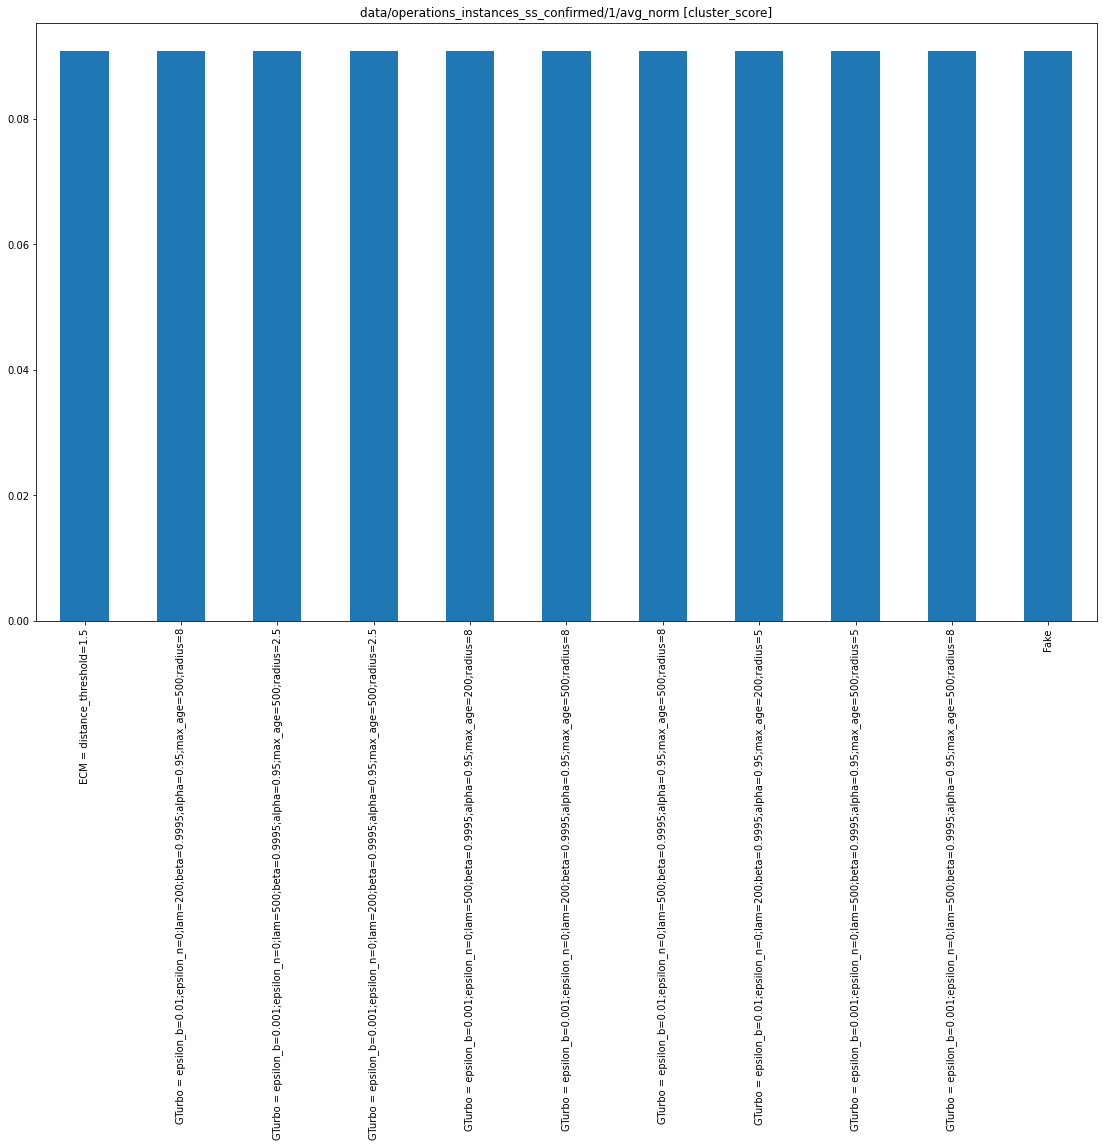

## OperationFile(layer='no_softskills', test_subpath='1/no_softskills', full_path='data/operations_instances_ss_confirmed/1/no_softskills') - cluster metrics

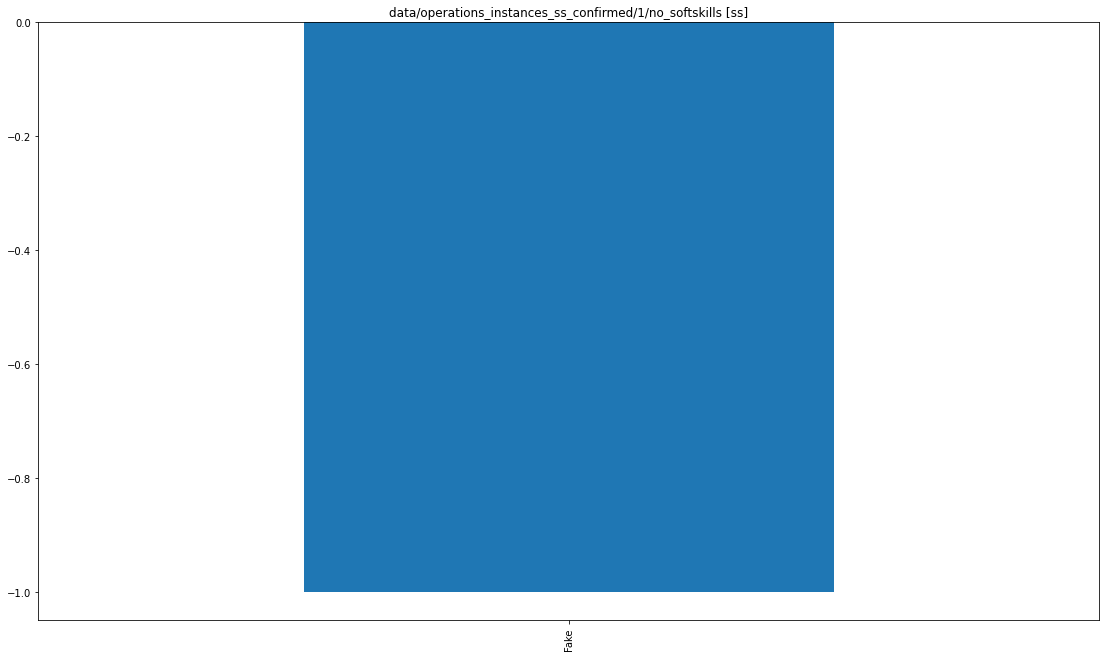

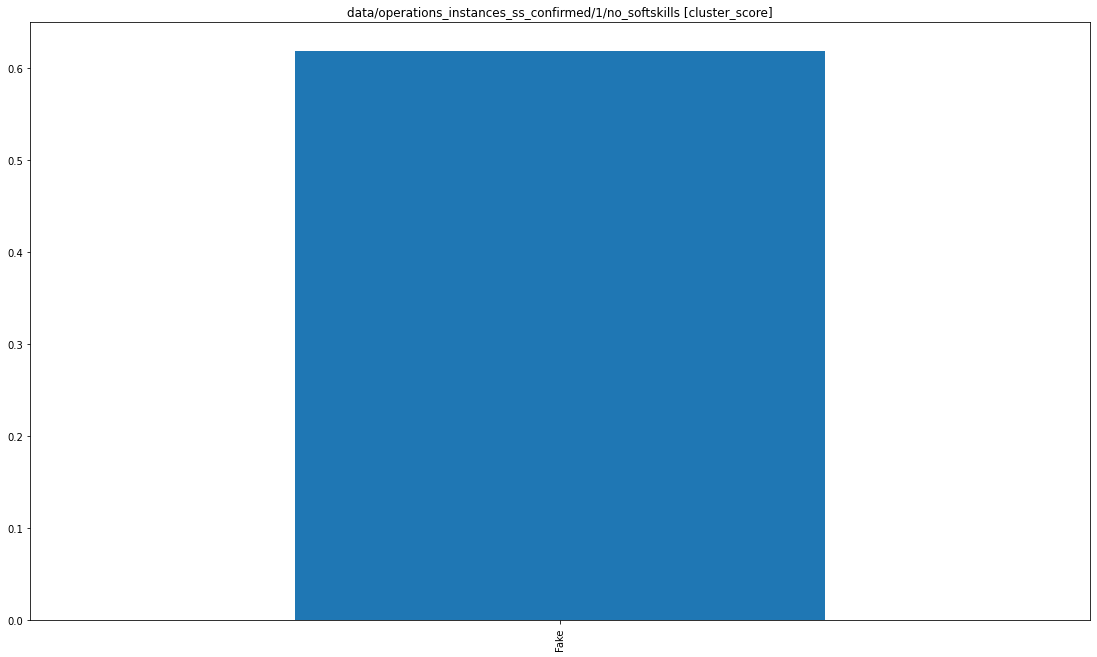

## OperationFile(layer='no_softskills_norm', test_subpath='1/no_softskills_norm', full_path='data/operations_instances_ss_confirmed/1/no_softskills_norm') - cluster metrics

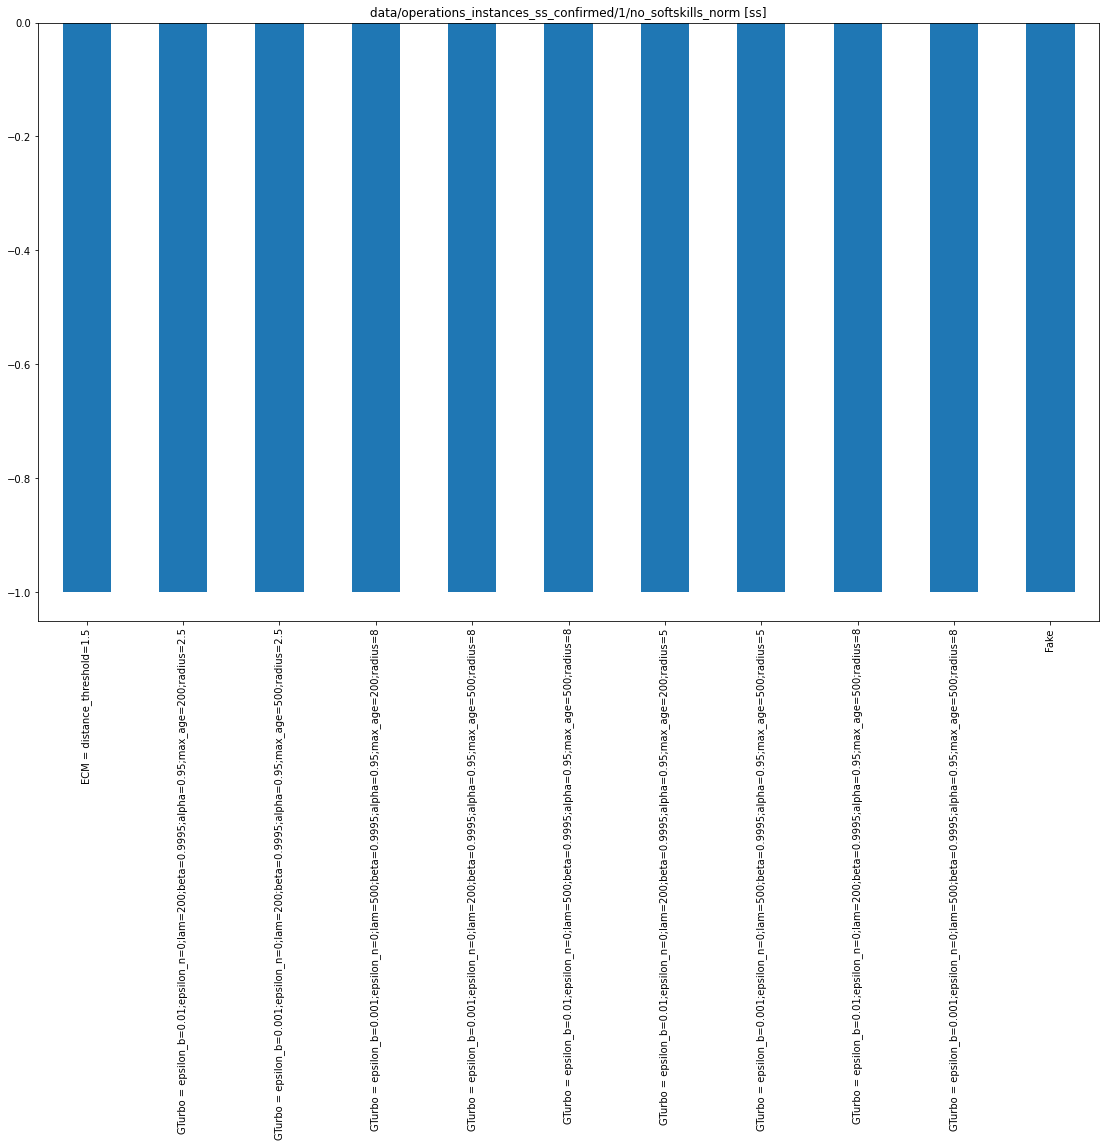

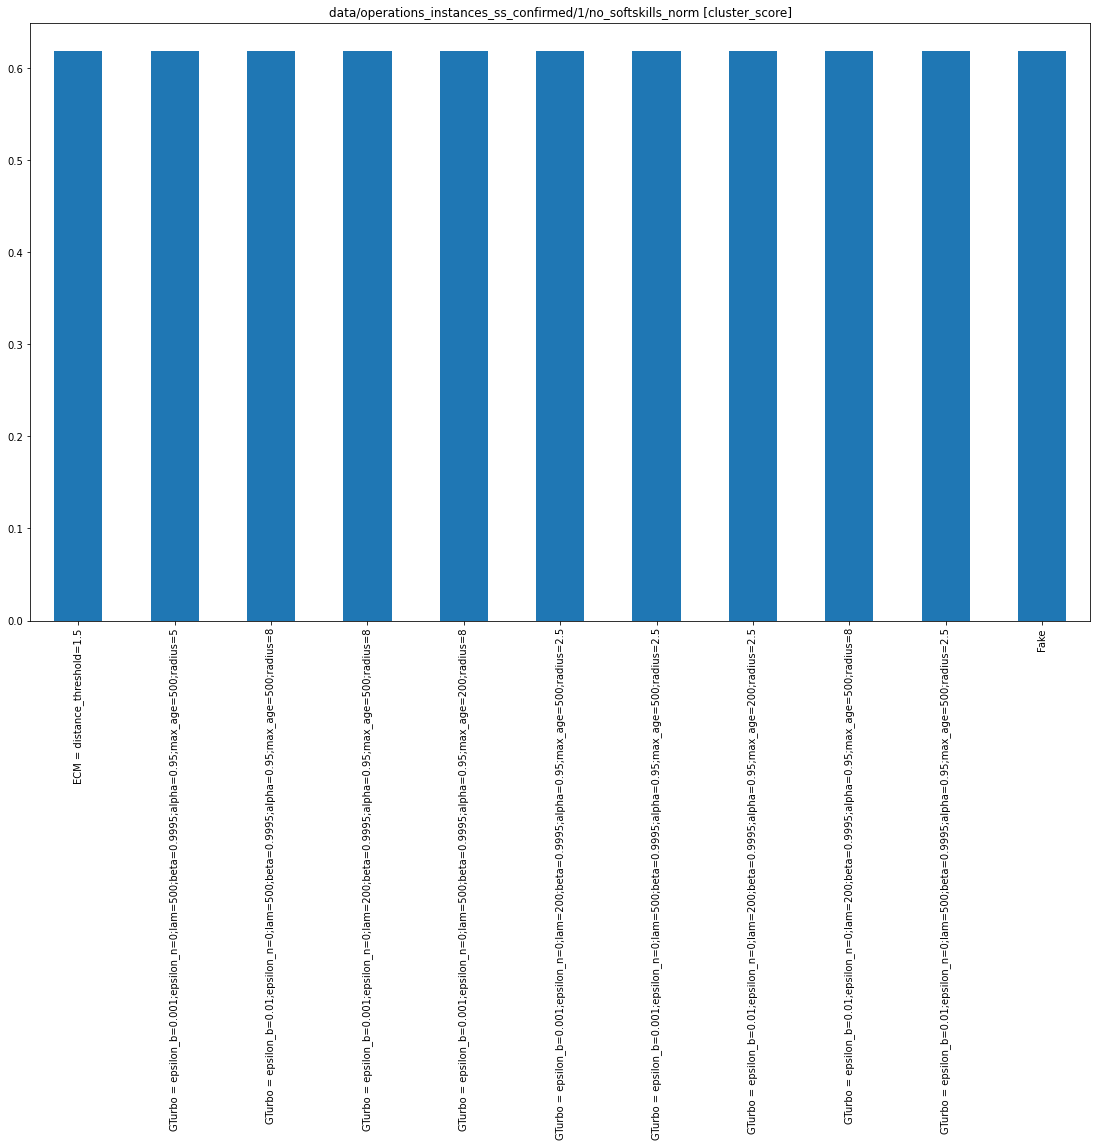

In [49]:
operations_file_to_good_by_cluster_metrics: Dict[str, Dict[str, None]] = {}

for operations_file in operations_files:

    display(Markdown(f'## {operations_file} - cluster metrics'))

    operations_file_to_good_by_cluster_metrics[operations_file.full_path] = {}

    name_to_cluster_metrics = operations_file_to_name_to_cluster_metrics[operations_file.full_path]

    cluster_metric_df = pd.DataFrame.from_dict(name_to_cluster_metrics, orient='index')

    for cluster_metric, _min, _max in cluster_metrics:
        n = 10
        z = cluster_metric_df[cluster_metric]
        z = z.sort_values(ascending=False).head(n)

        if "Fake" not in z.index:
            z = z.append(pd.Series([cluster_metric_df[cluster_metric]["Fake"]], index=["Fake"]))

        for name in z.index:
            operations_file_to_good_by_cluster_metrics[operations_file.full_path][name] = None

        plot = z.plot(kind='bar', figsize=(19,11))
        plot.set_title(f"{operations_file.full_path} [{cluster_metric}]")
        plt.show()


## OperationFile(layer='concat_norm', test_subpath='1/concat_norm', full_path='data/operations_instances_ss_confirmed/1/concat_norm') - matches metrics

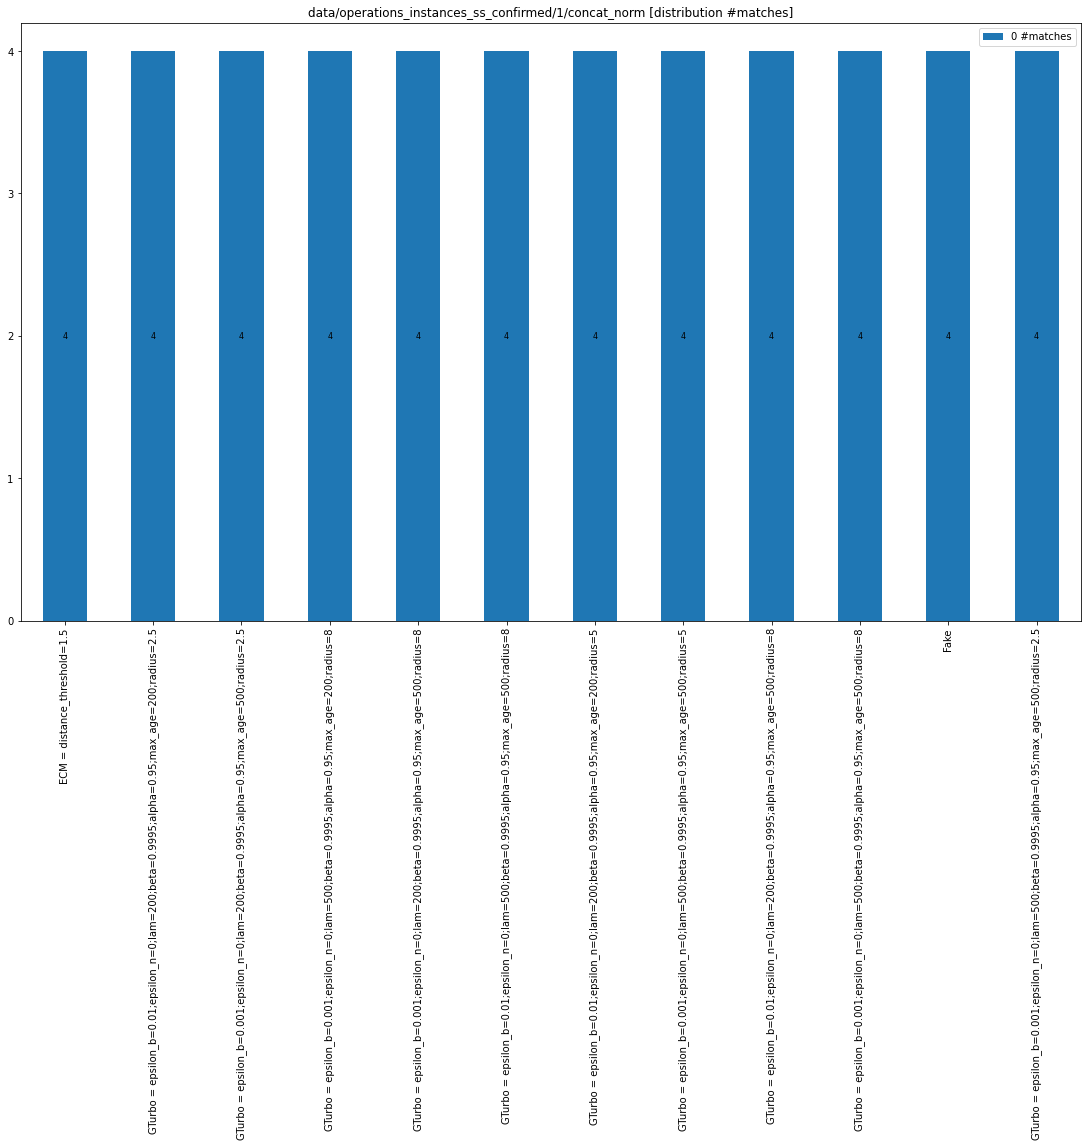

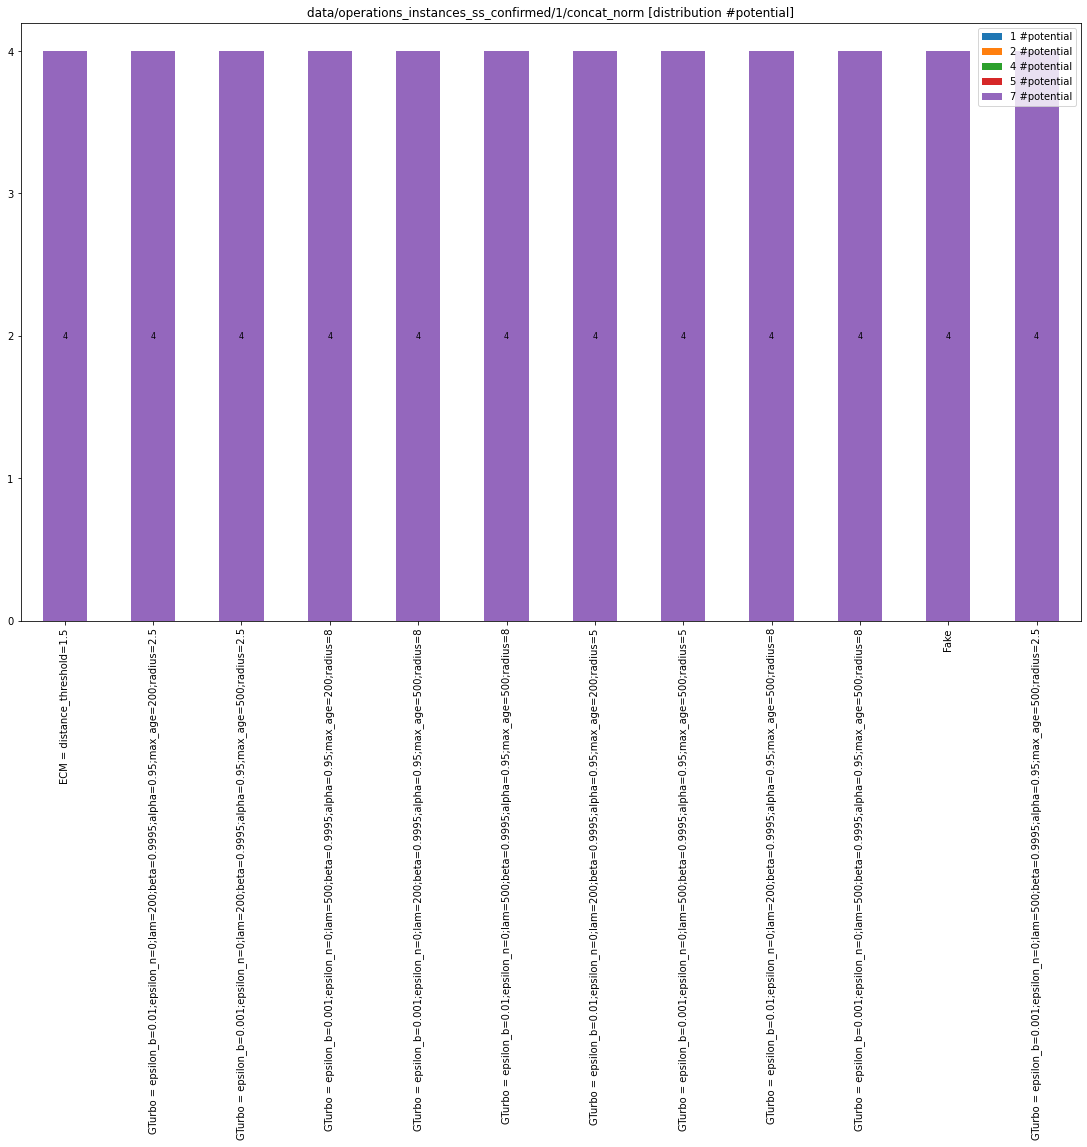

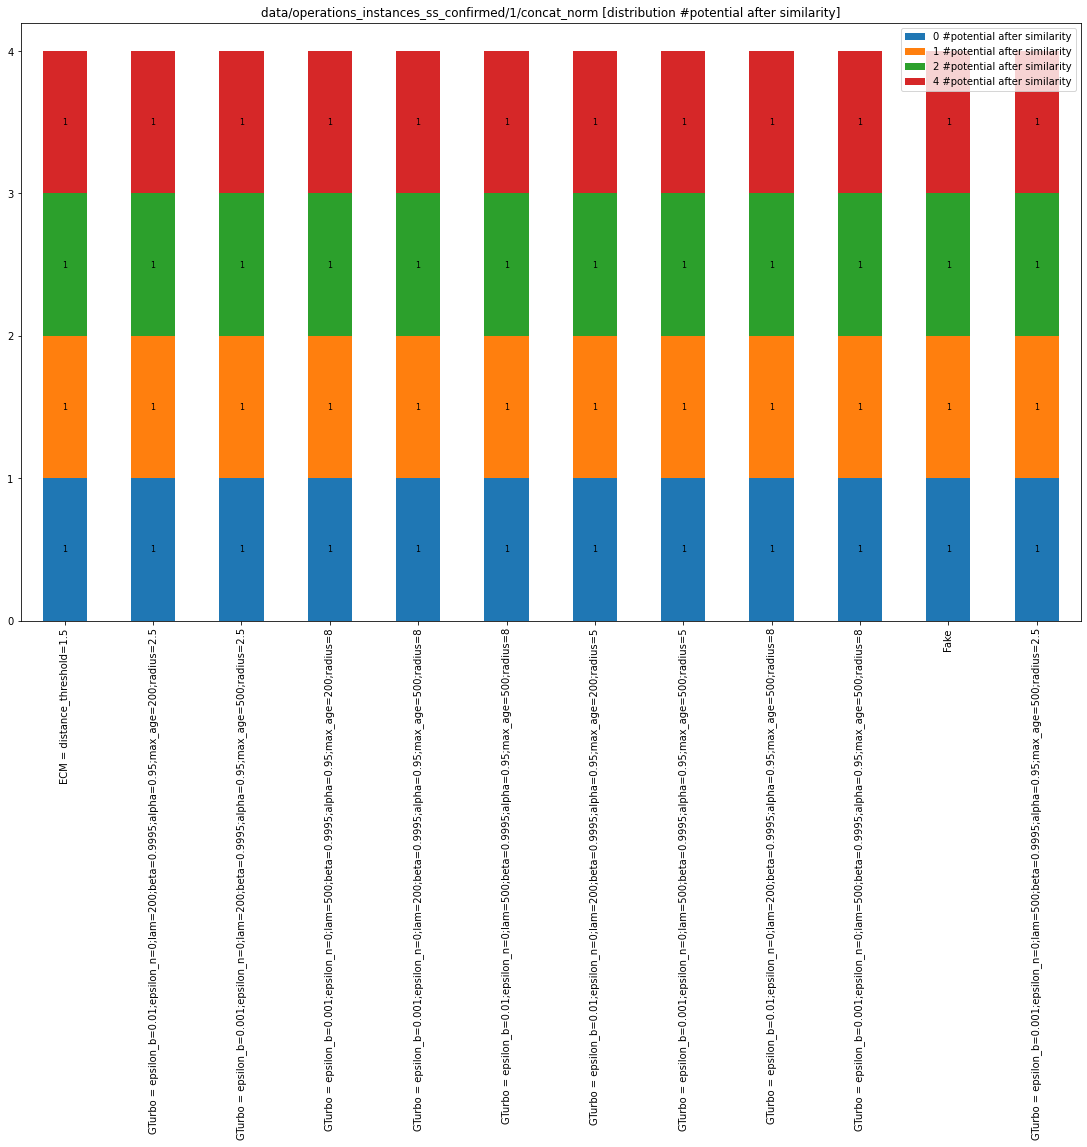

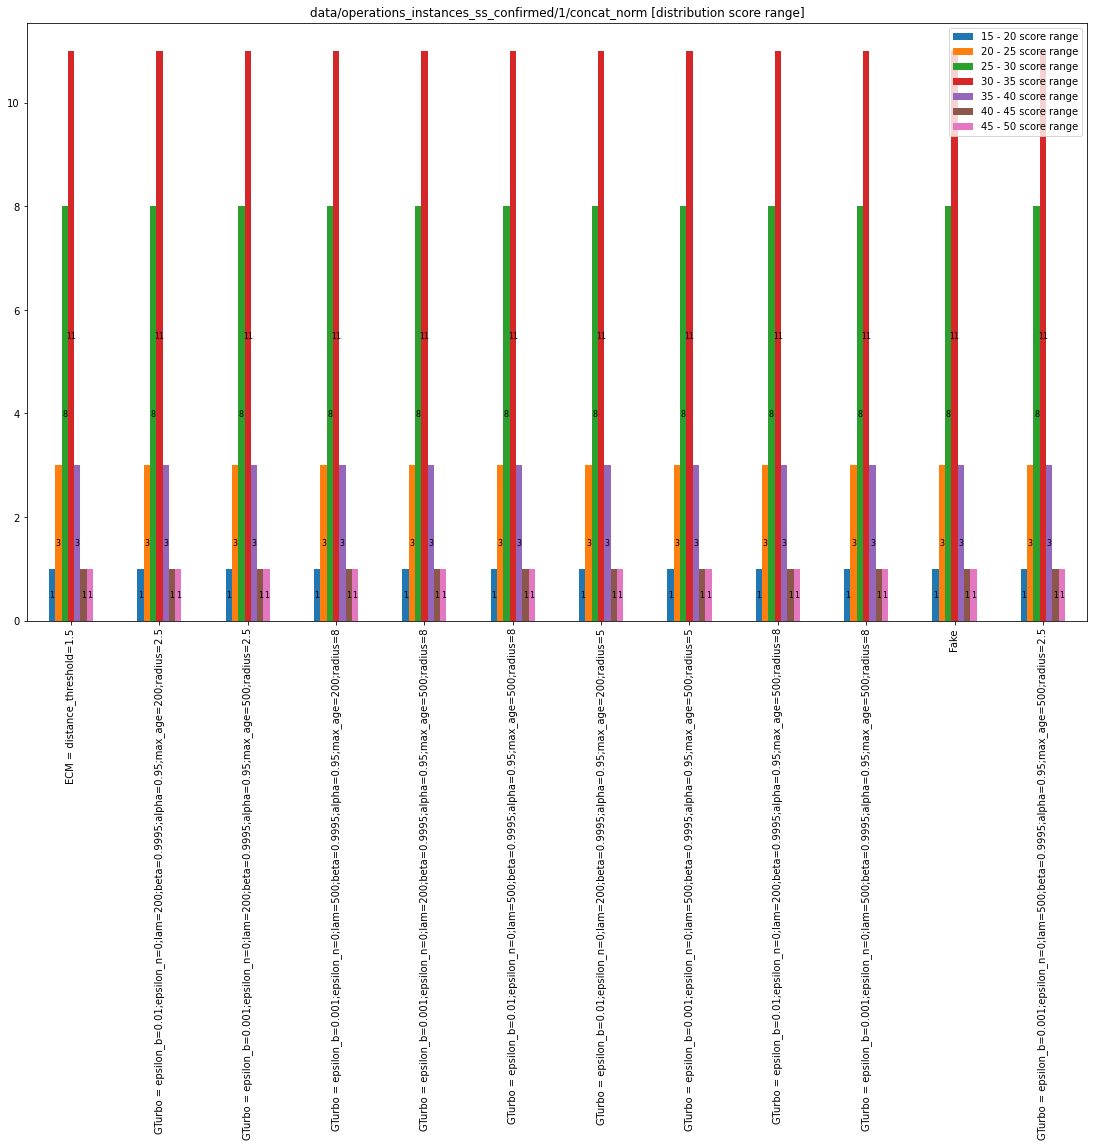

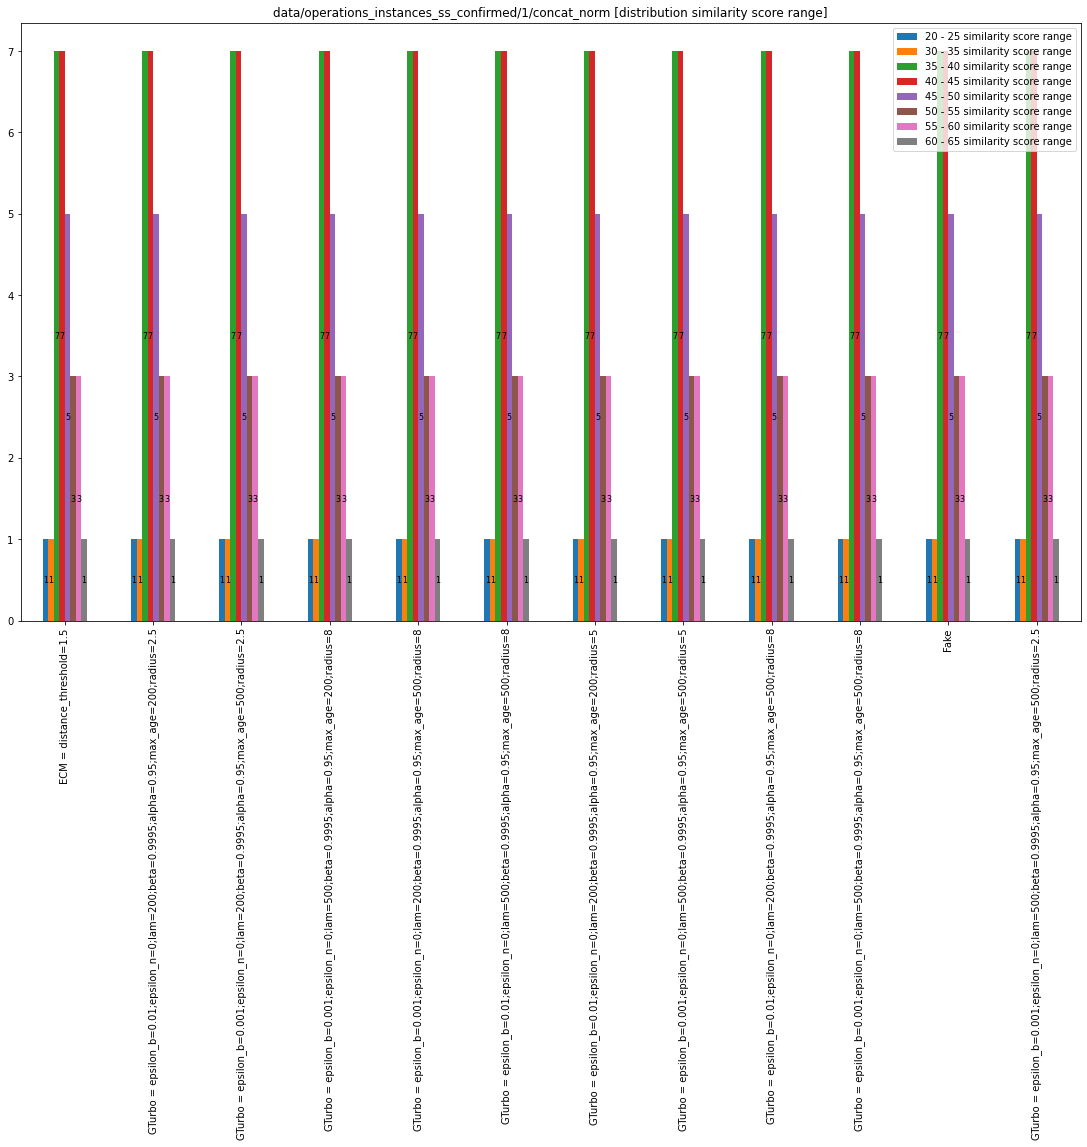

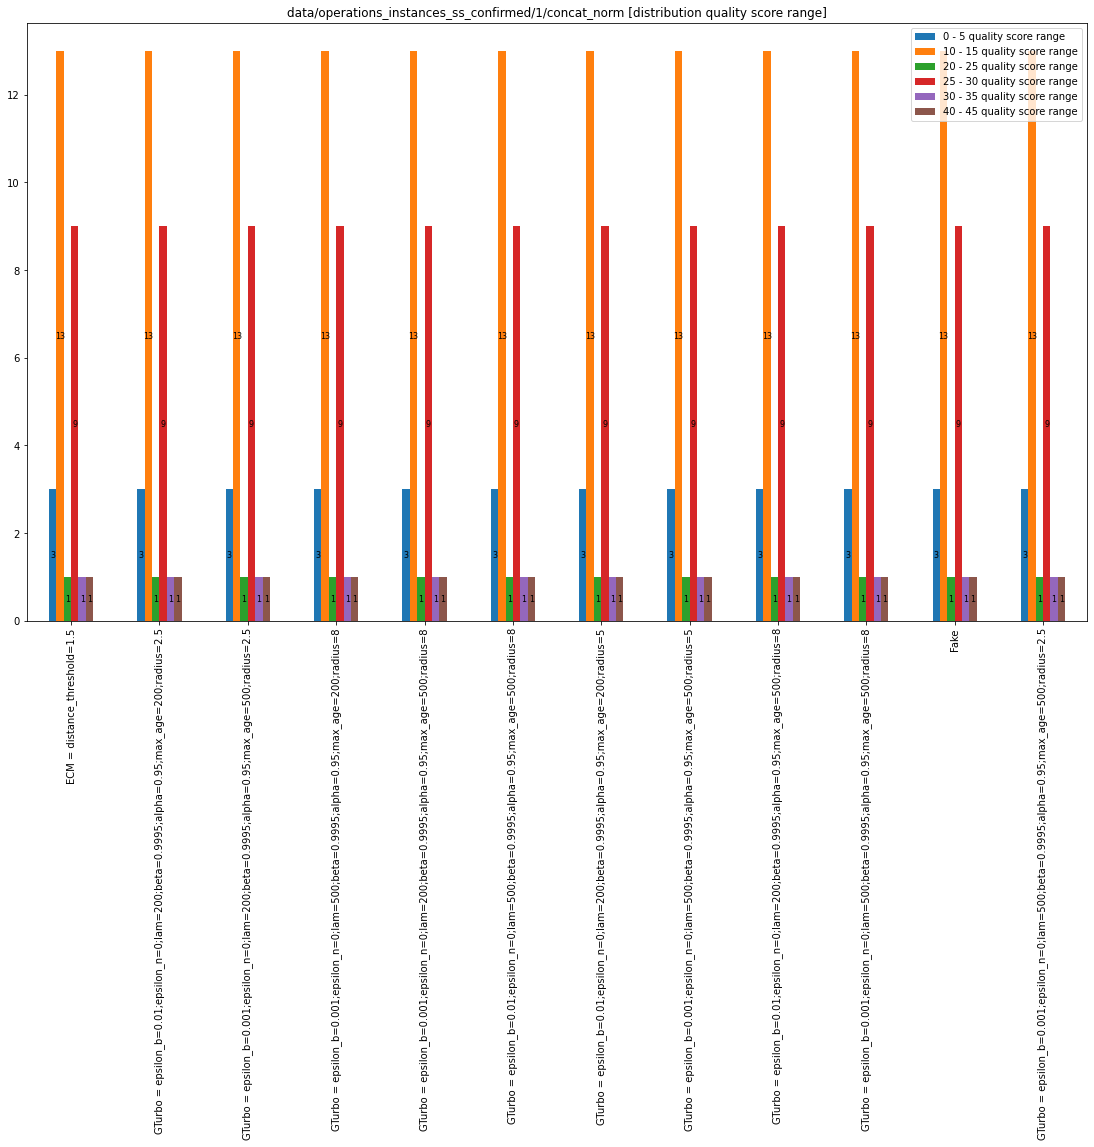

## OperationFile(layer='concat', test_subpath='1/concat', full_path='data/operations_instances_ss_confirmed/1/concat') - matches metrics

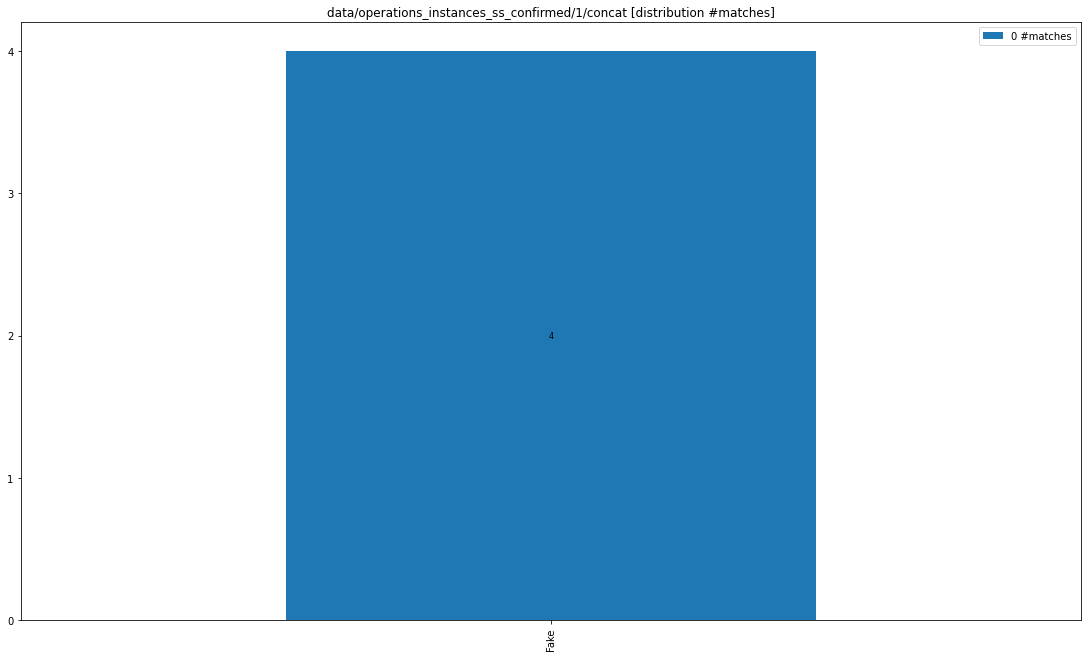

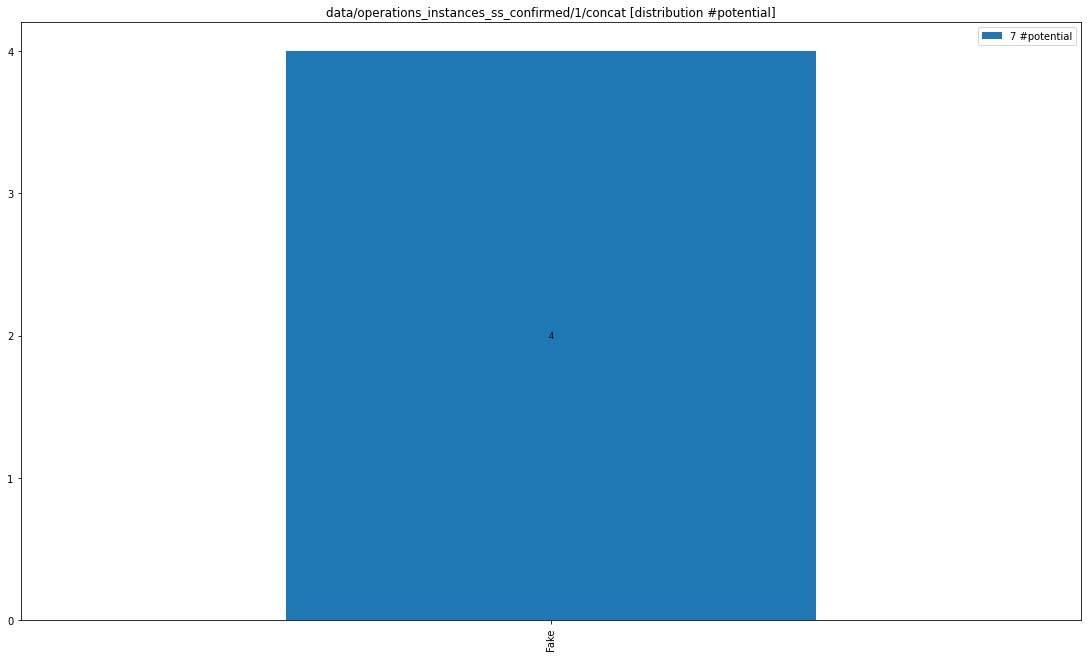

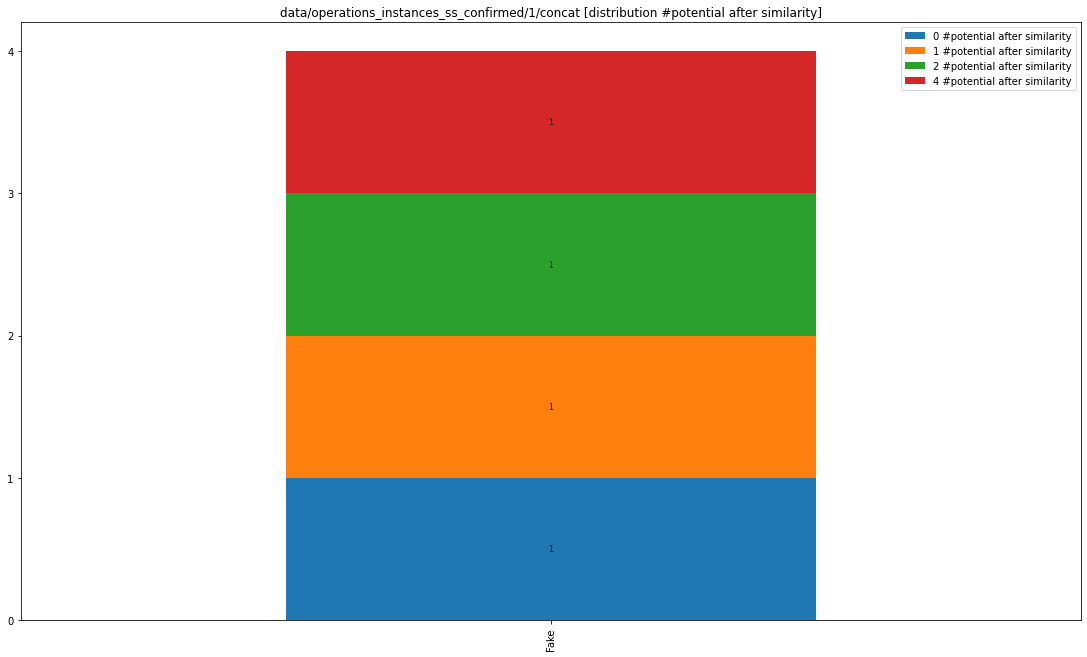

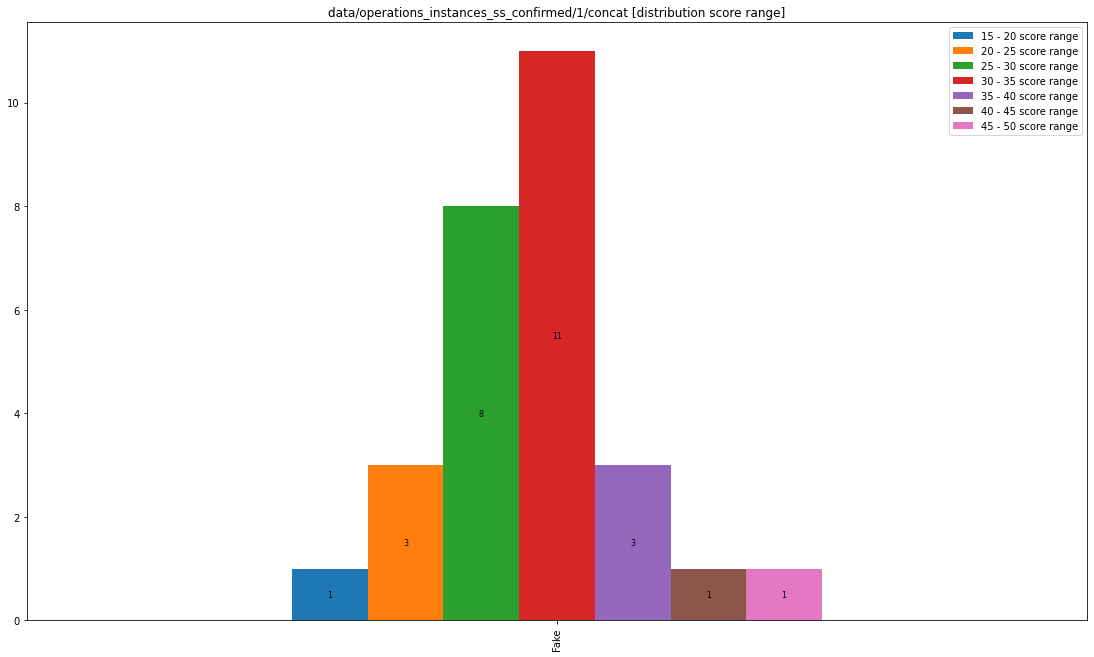

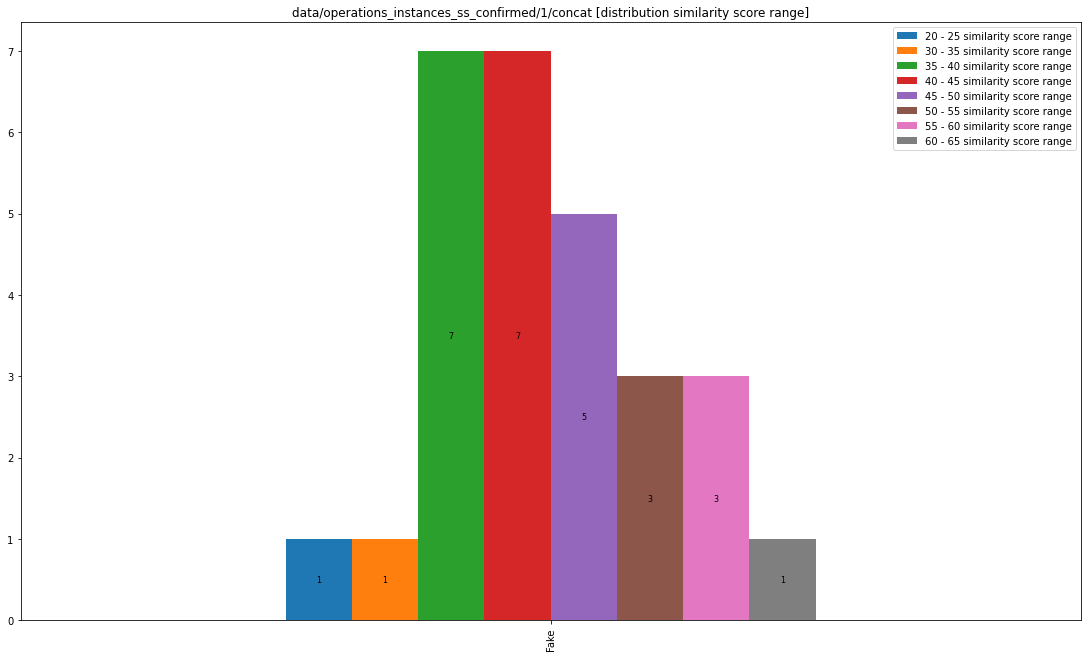

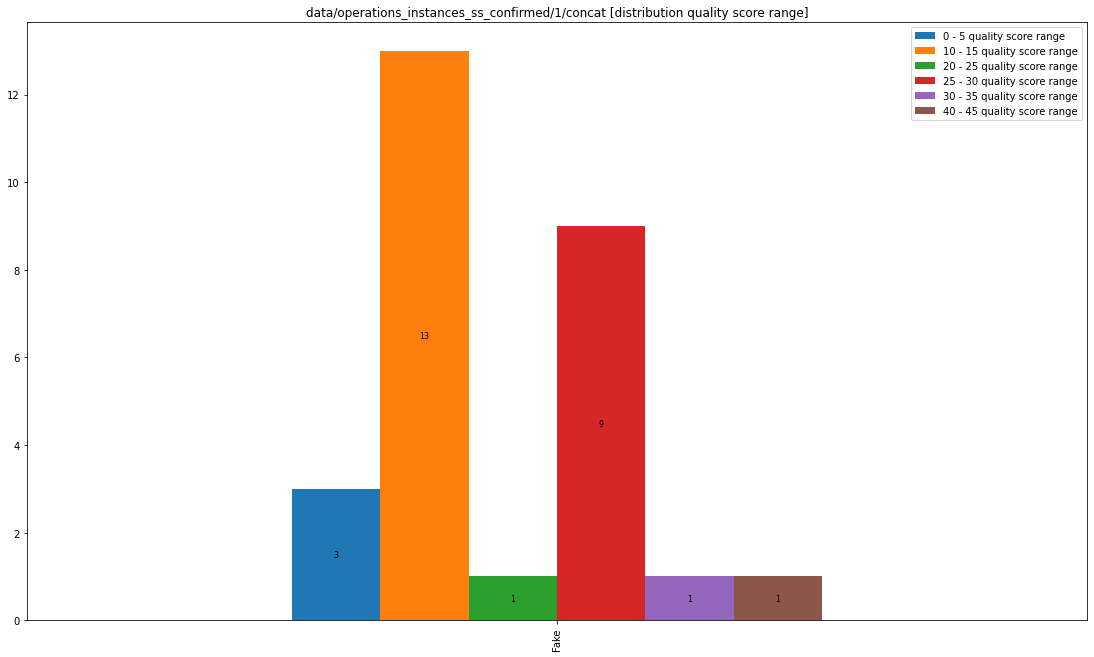

## OperationFile(layer='avg', test_subpath='1/avg', full_path='data/operations_instances_ss_confirmed/1/avg') - matches metrics

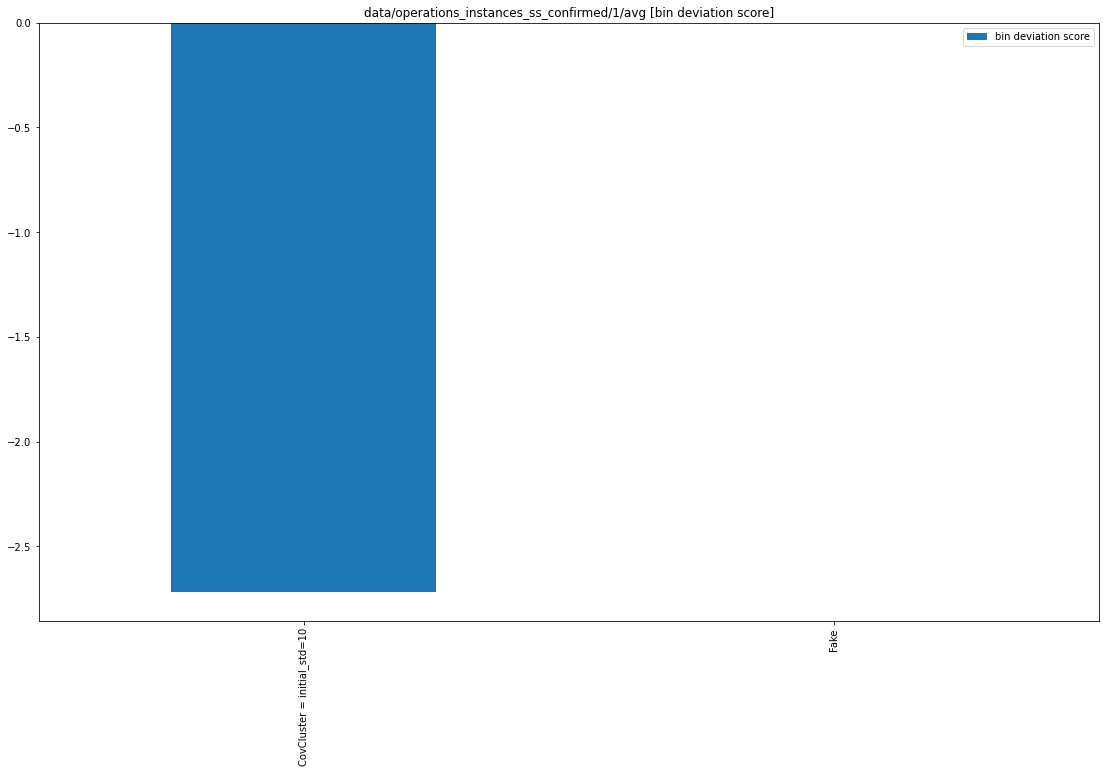

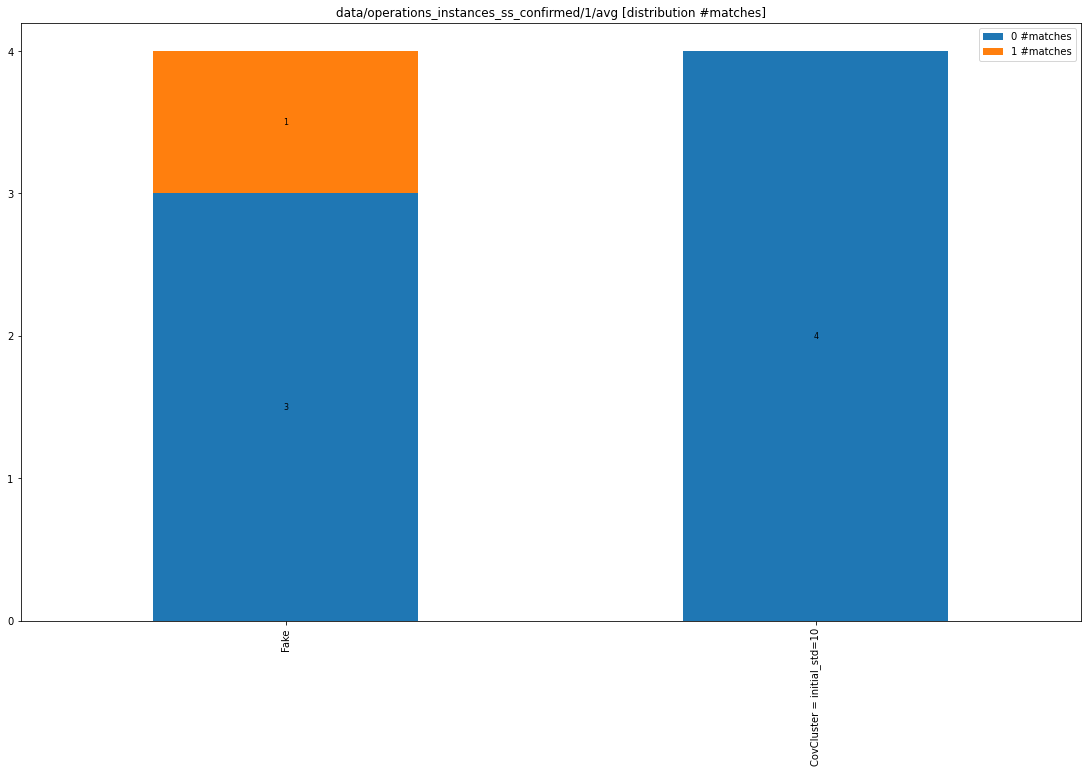

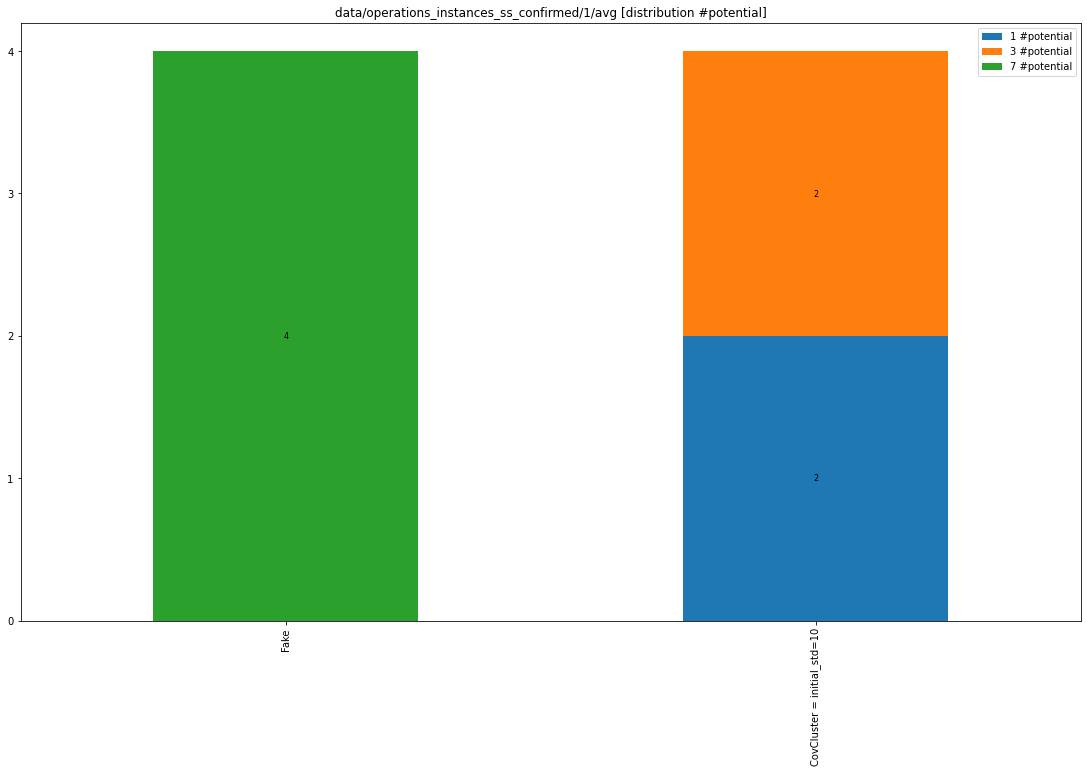

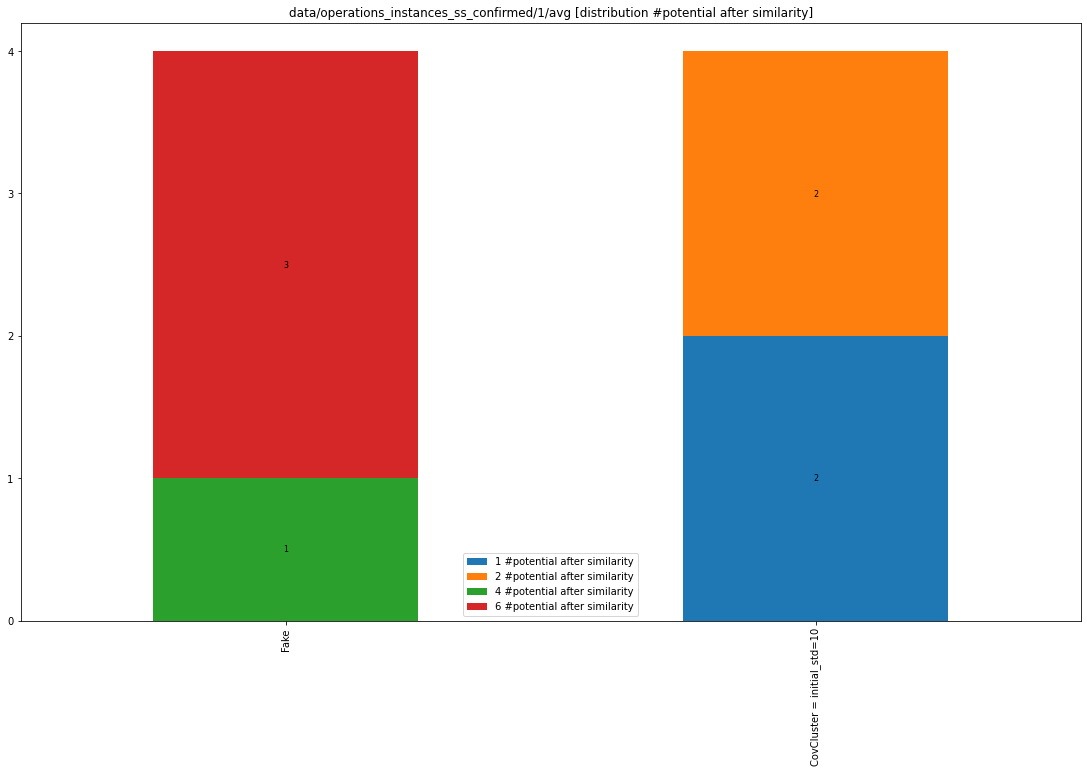

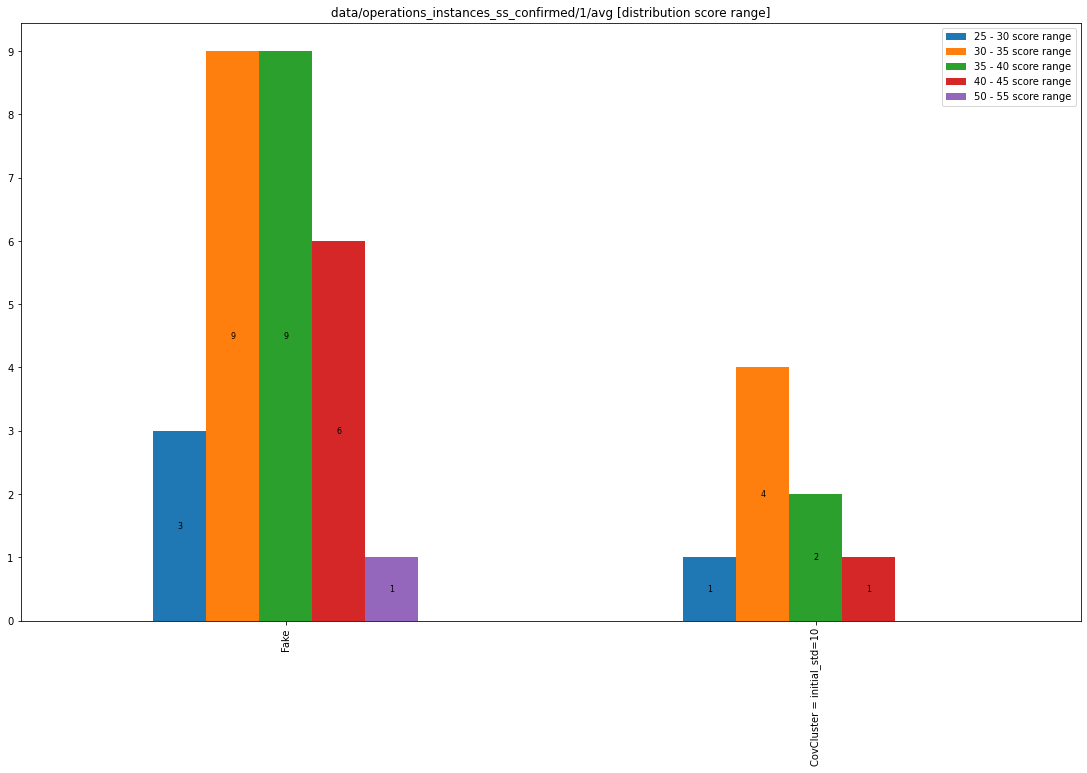

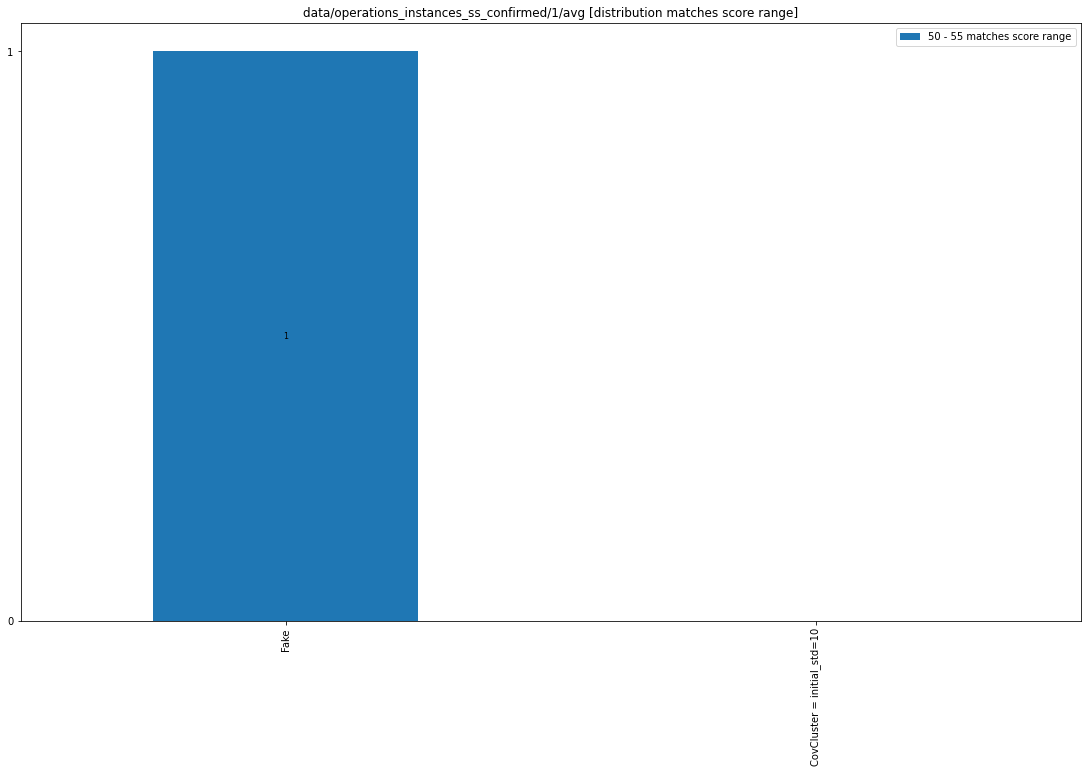

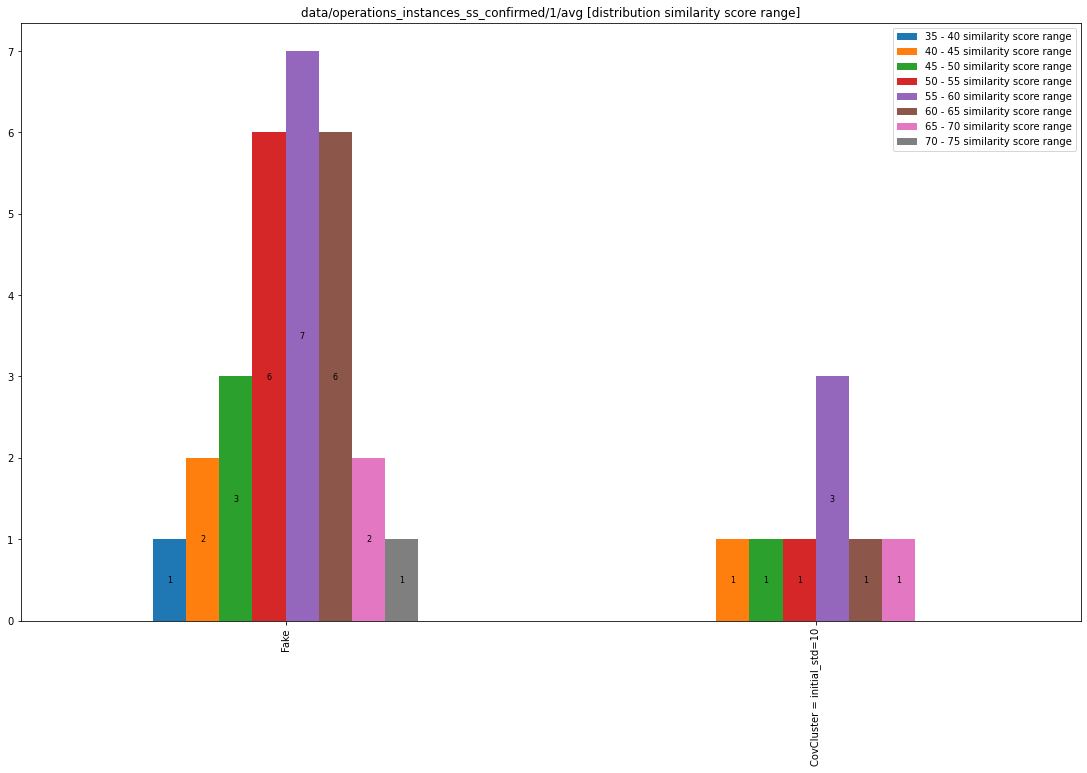

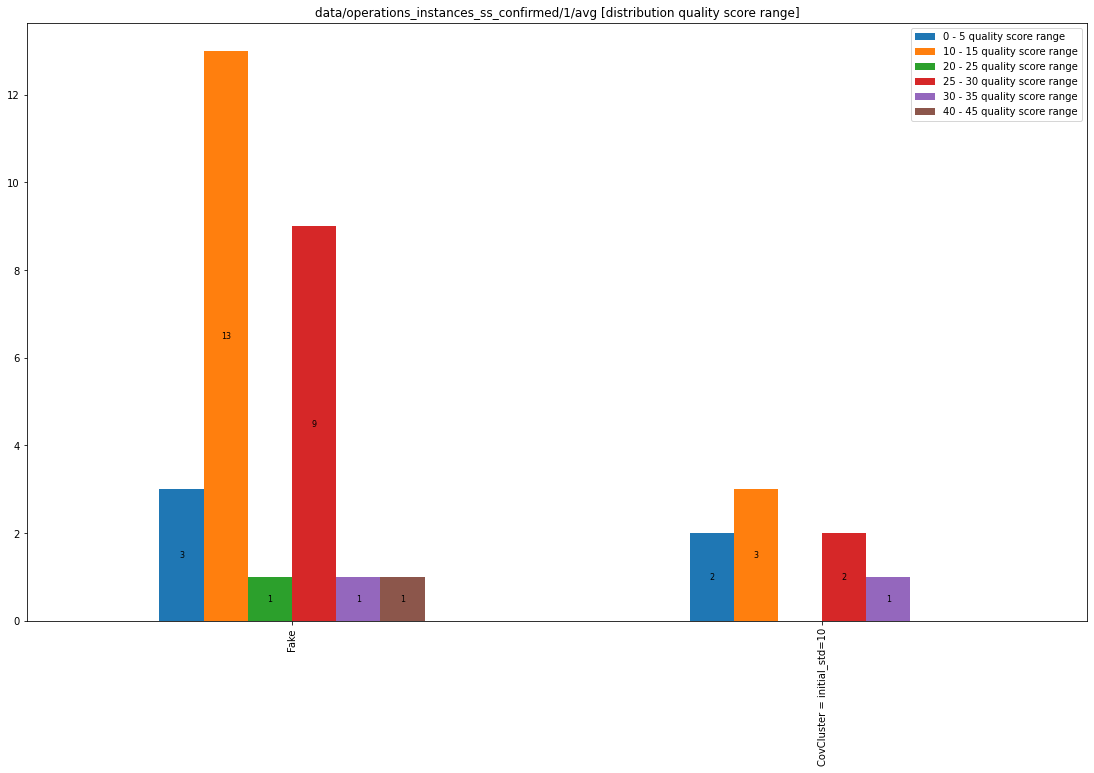

## OperationFile(layer='avg_norm', test_subpath='1/avg_norm', full_path='data/operations_instances_ss_confirmed/1/avg_norm') - matches metrics

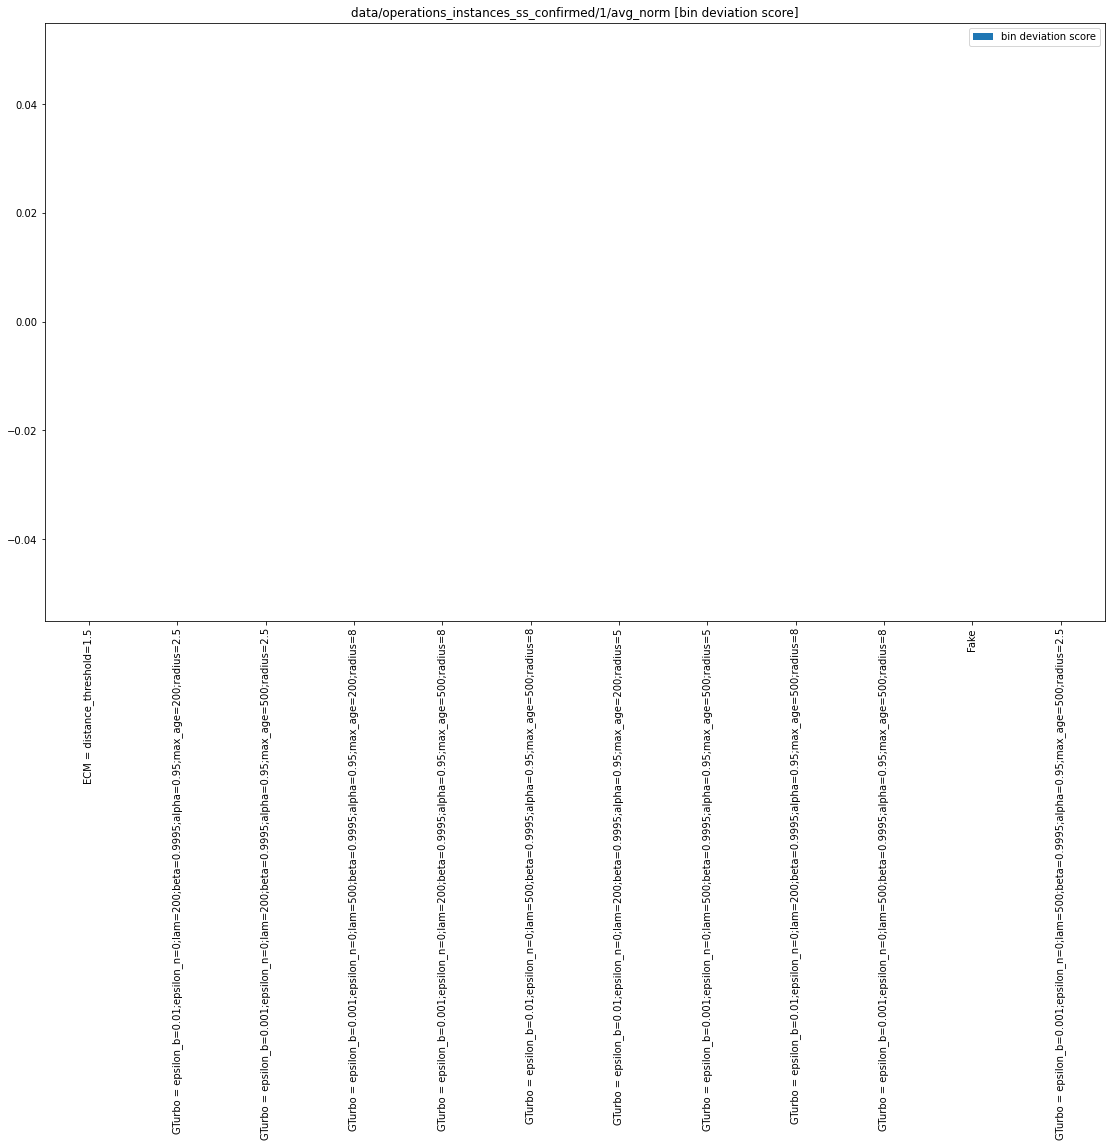

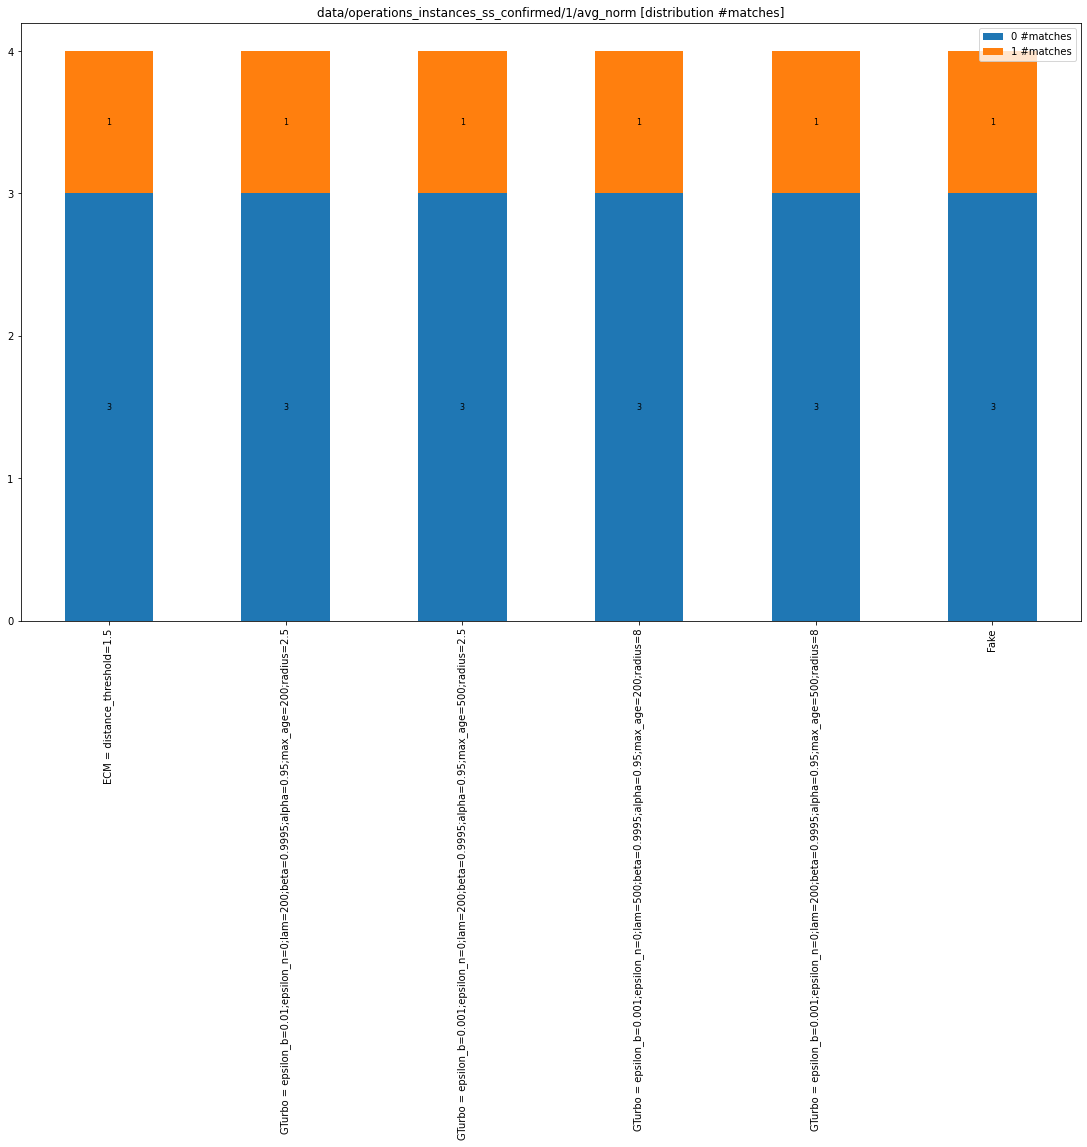

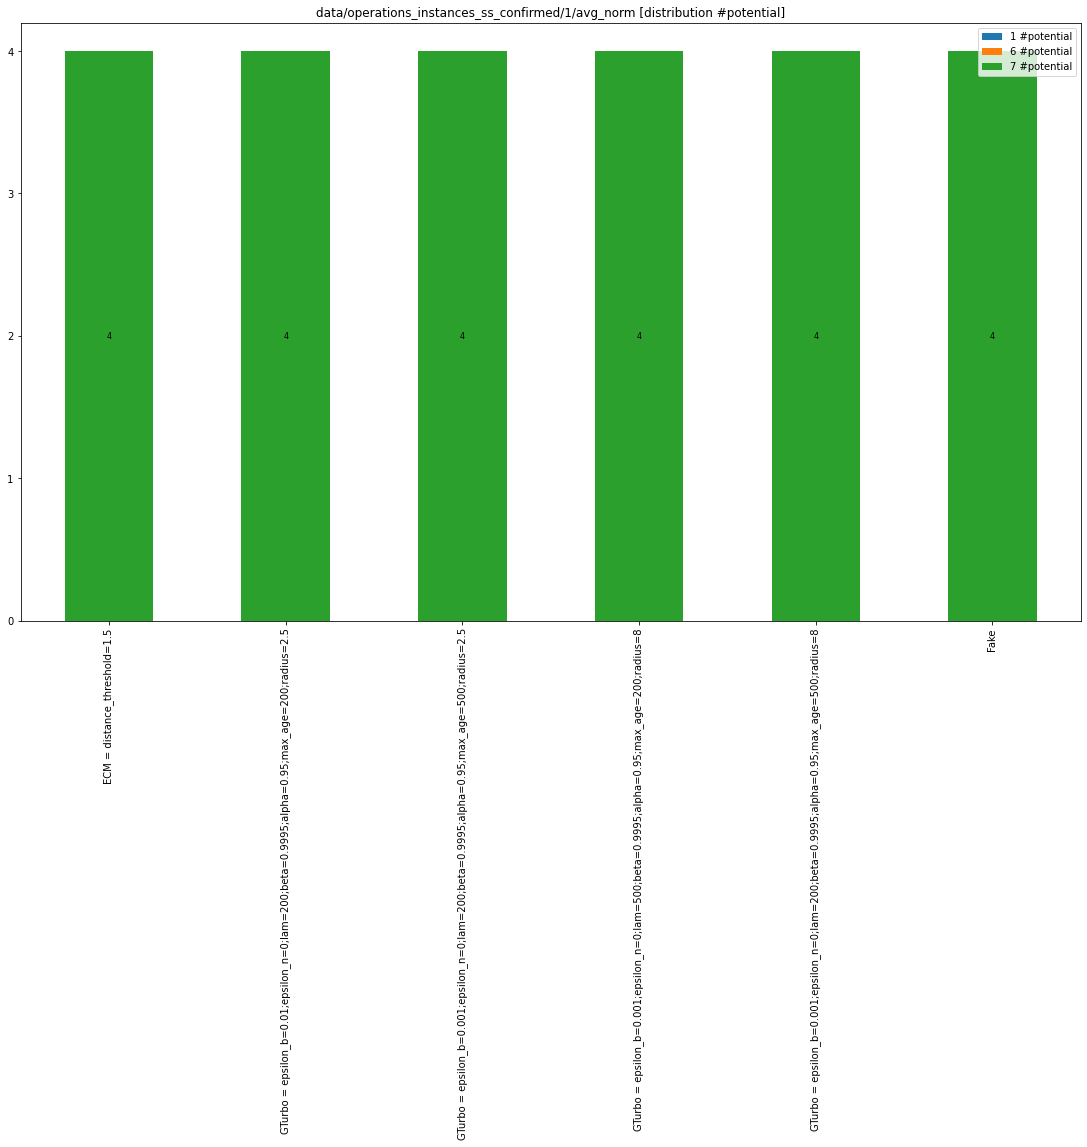

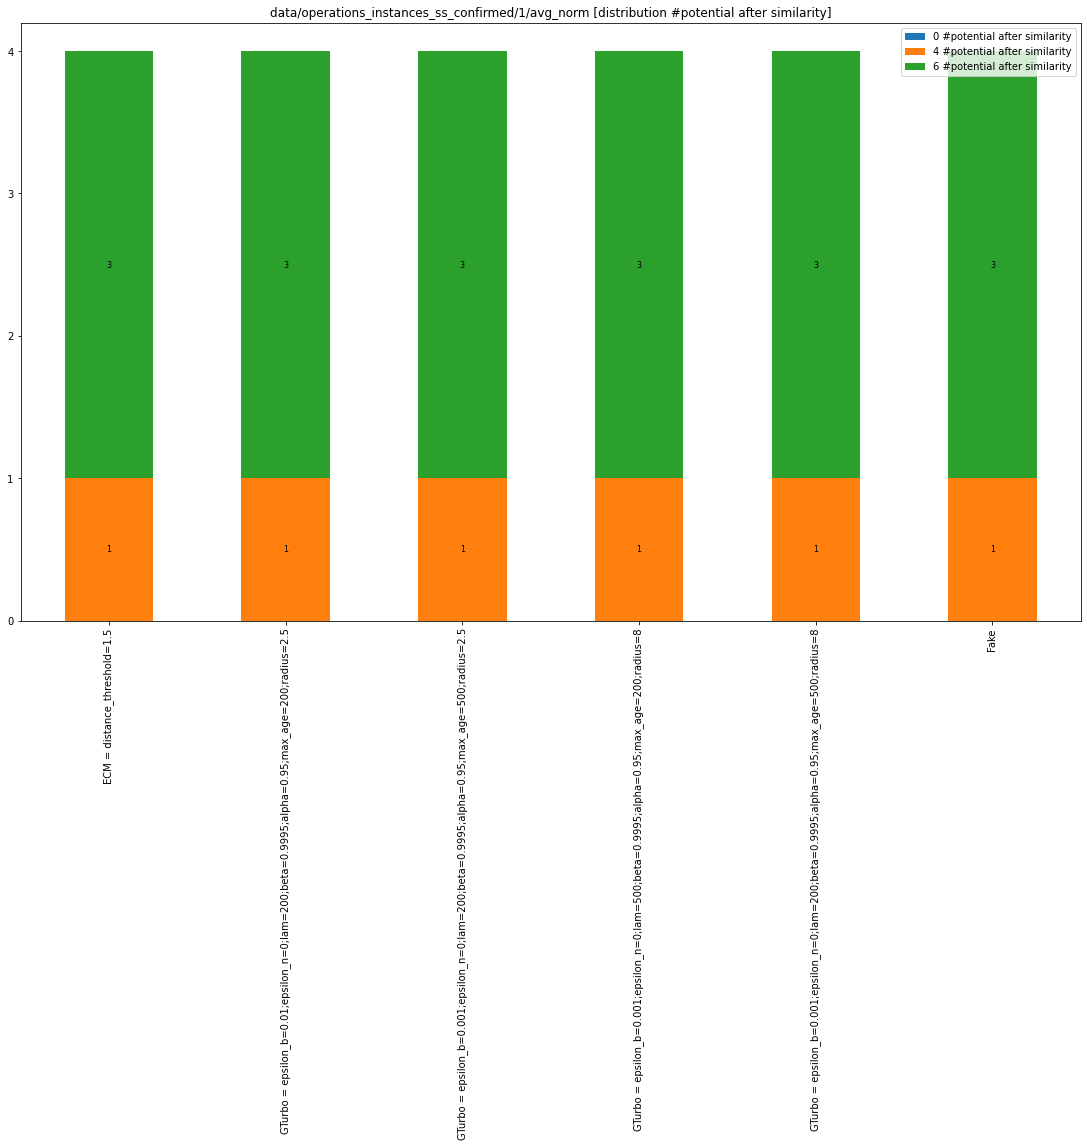

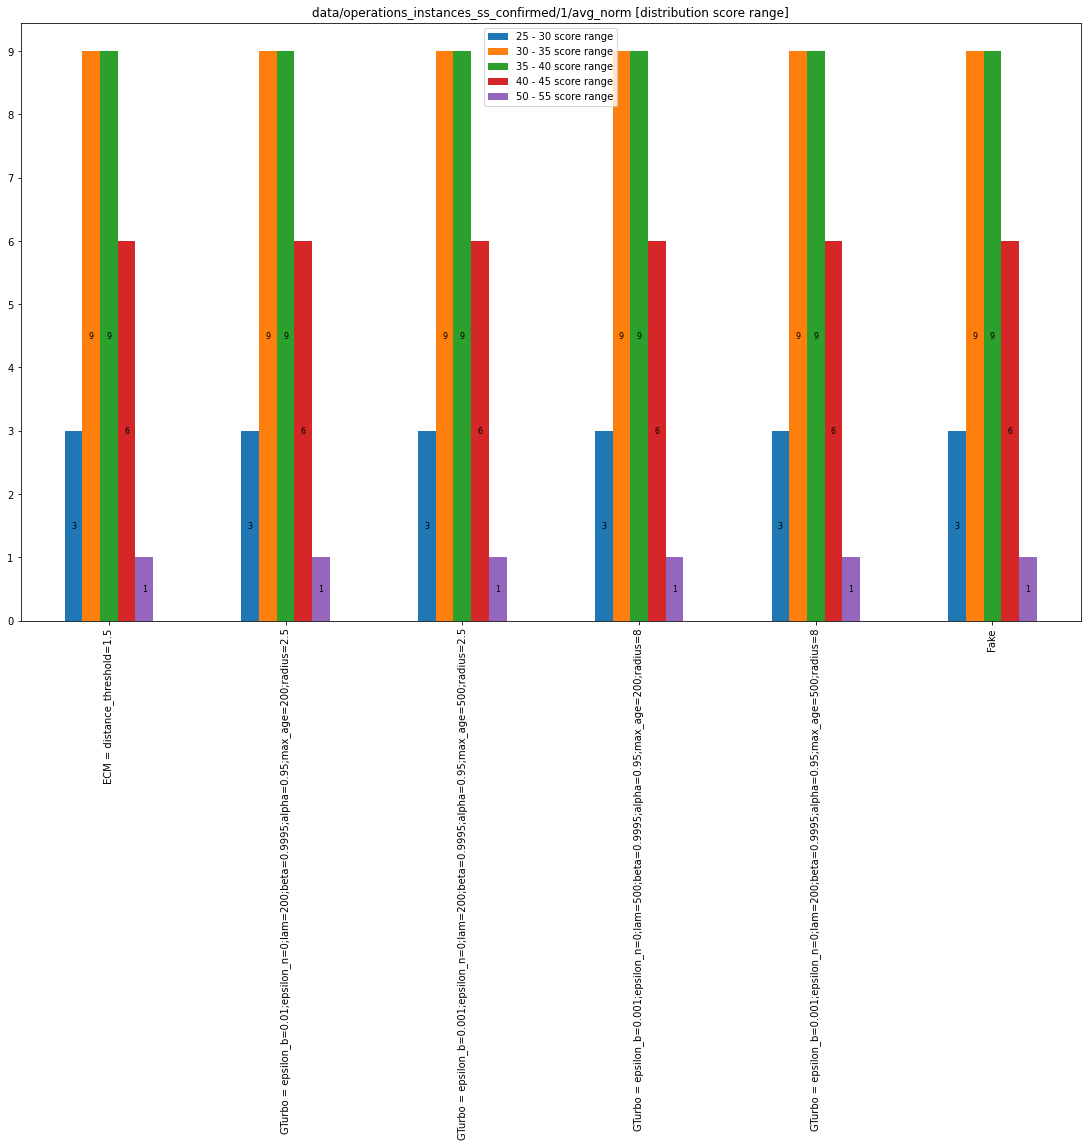

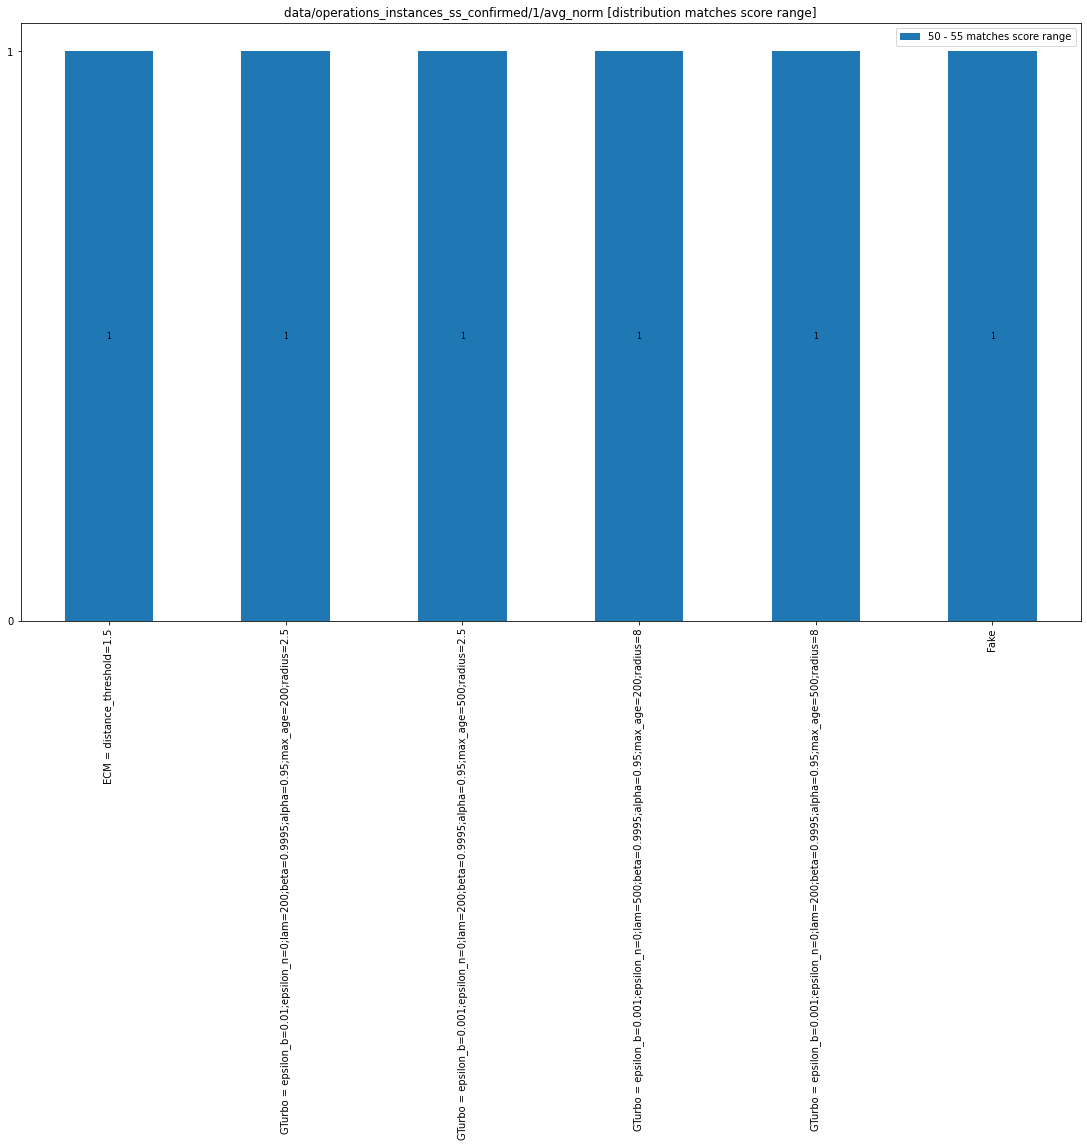

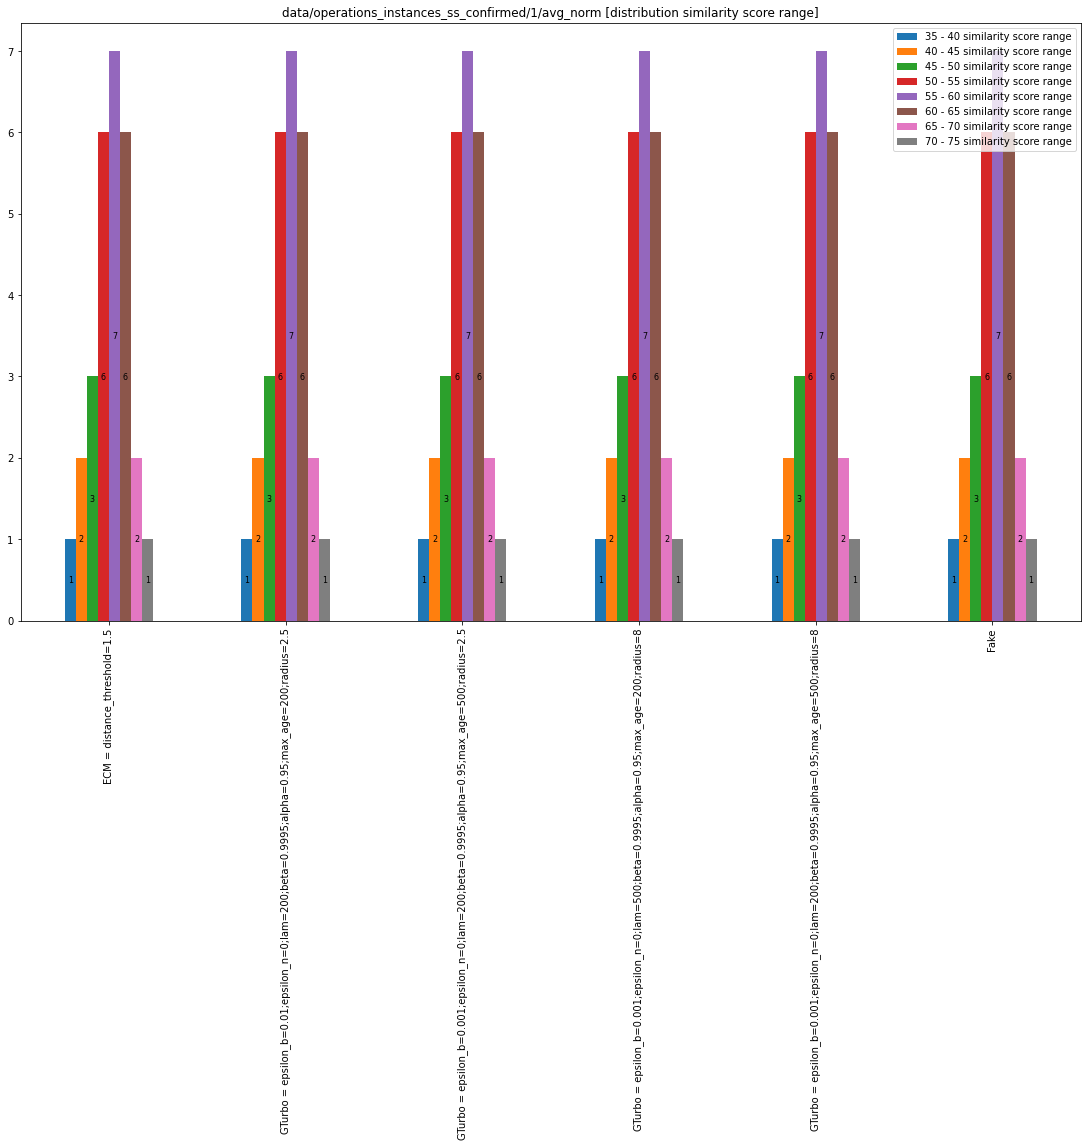

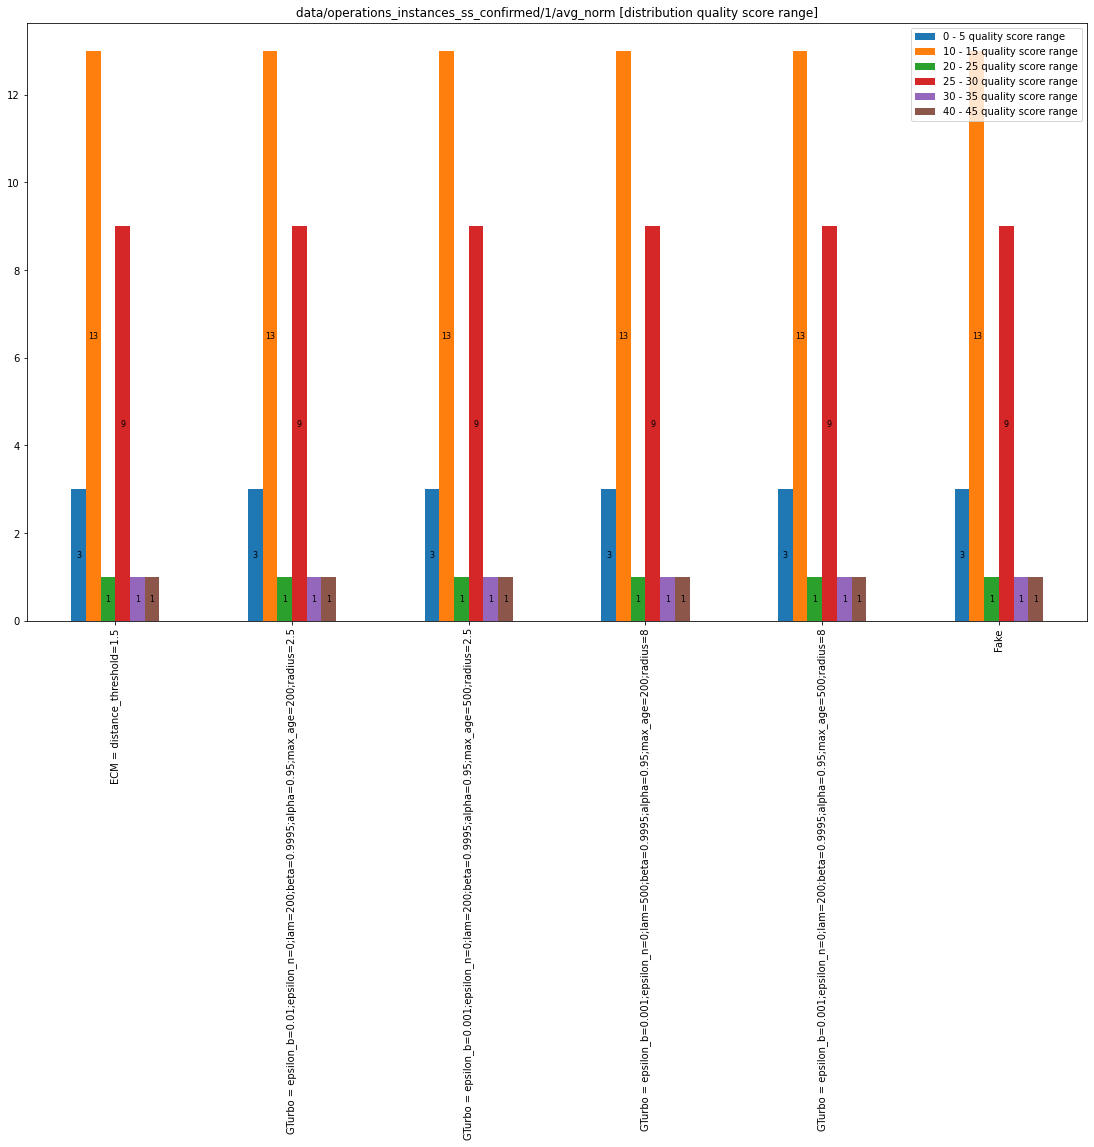

## OperationFile(layer='no_softskills', test_subpath='1/no_softskills', full_path='data/operations_instances_ss_confirmed/1/no_softskills') - matches metrics

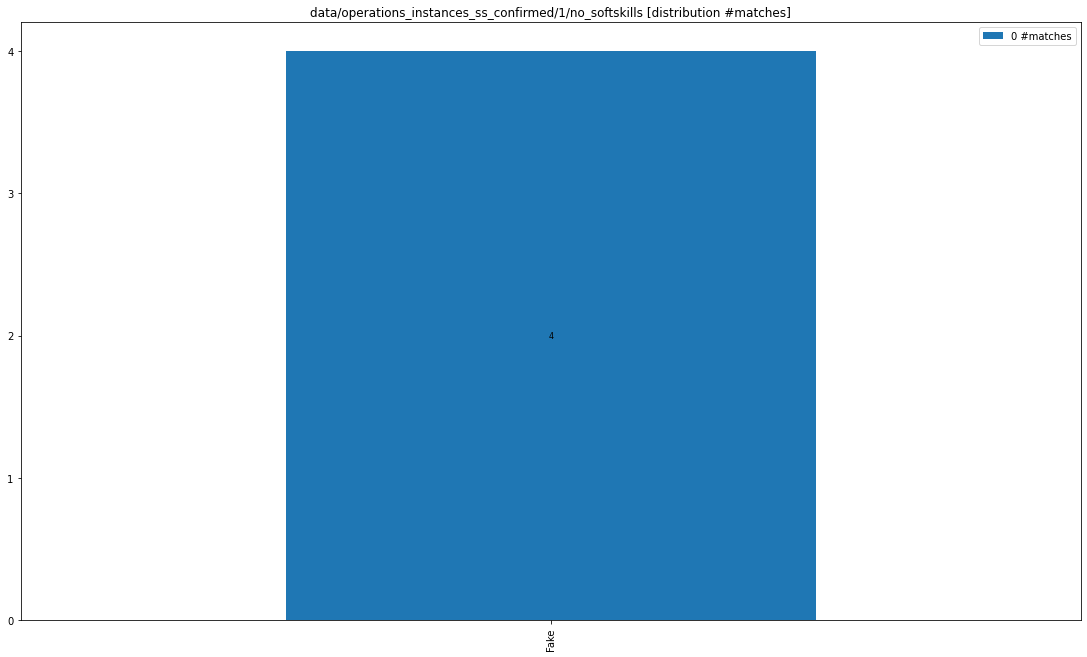

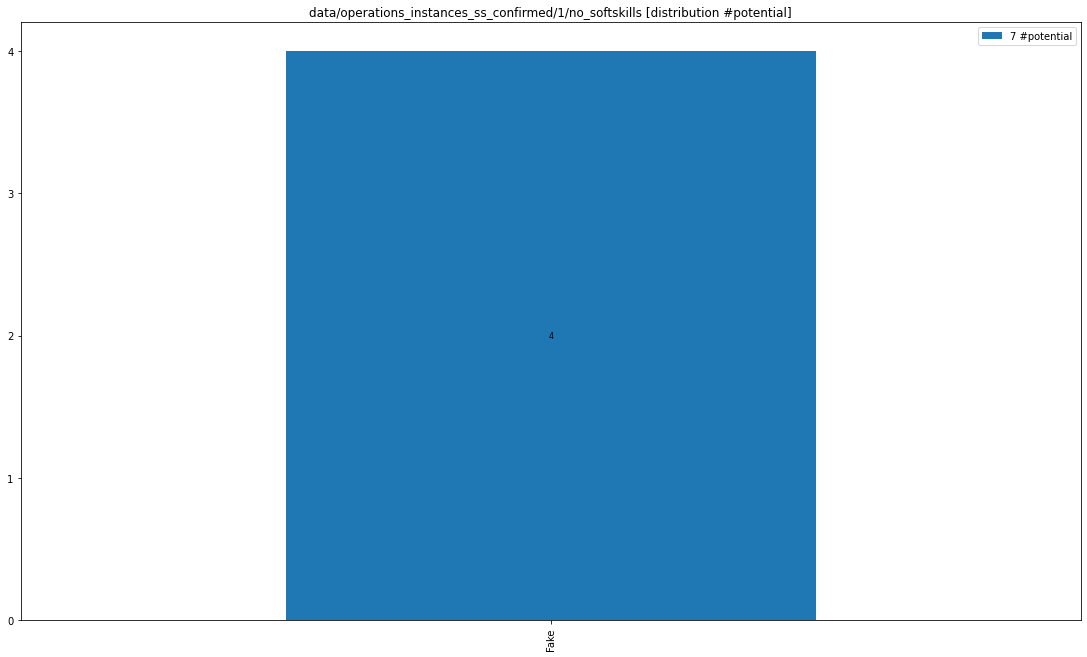

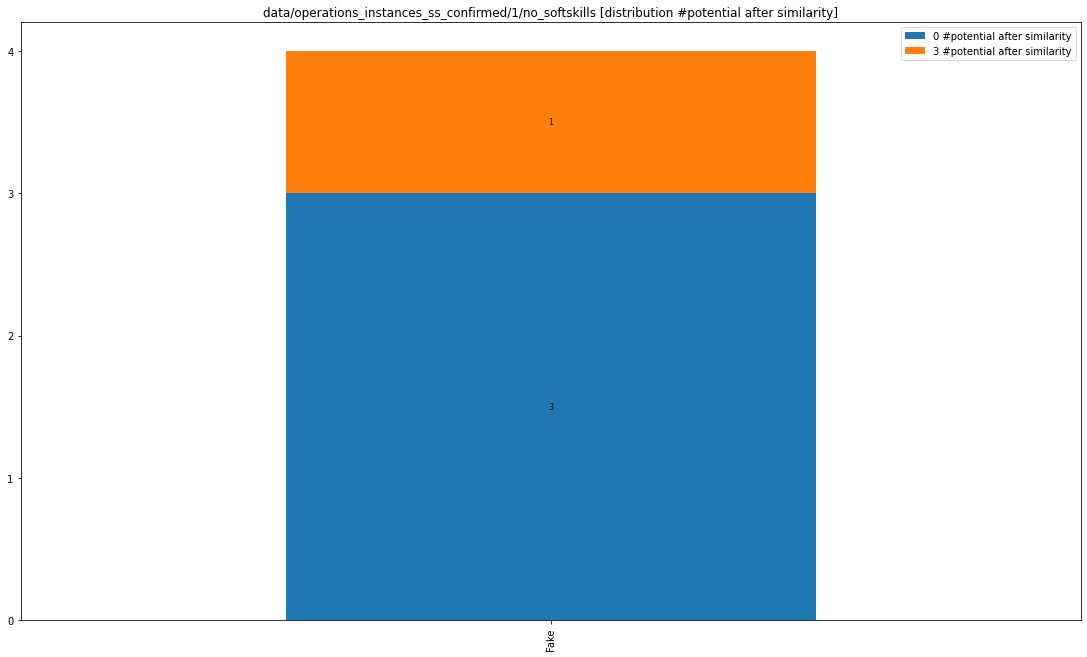

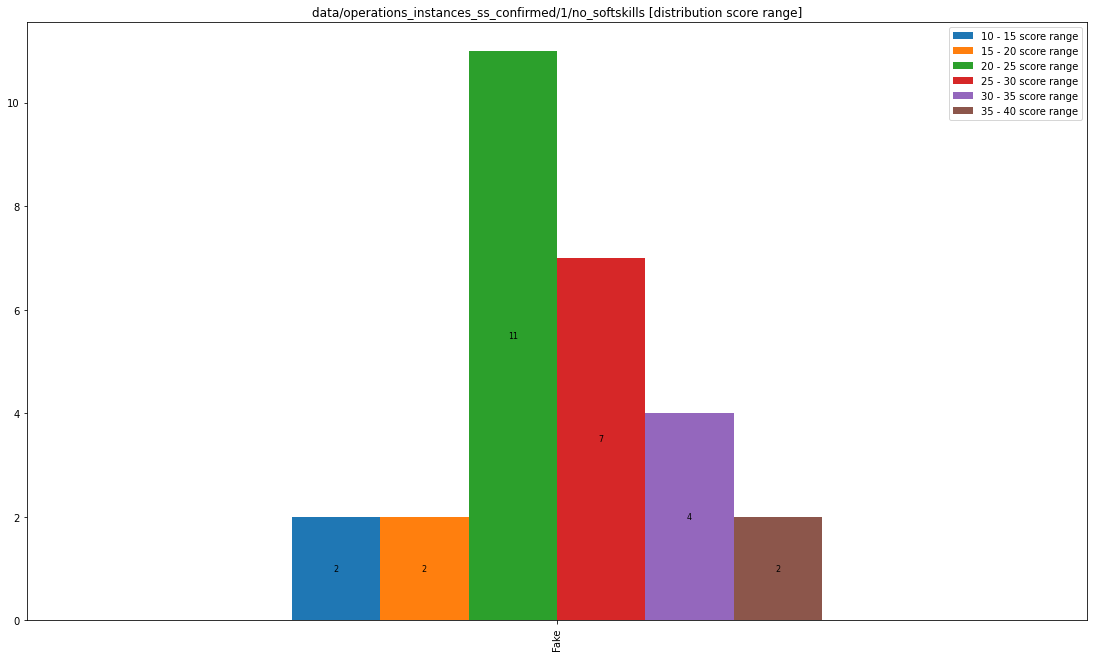

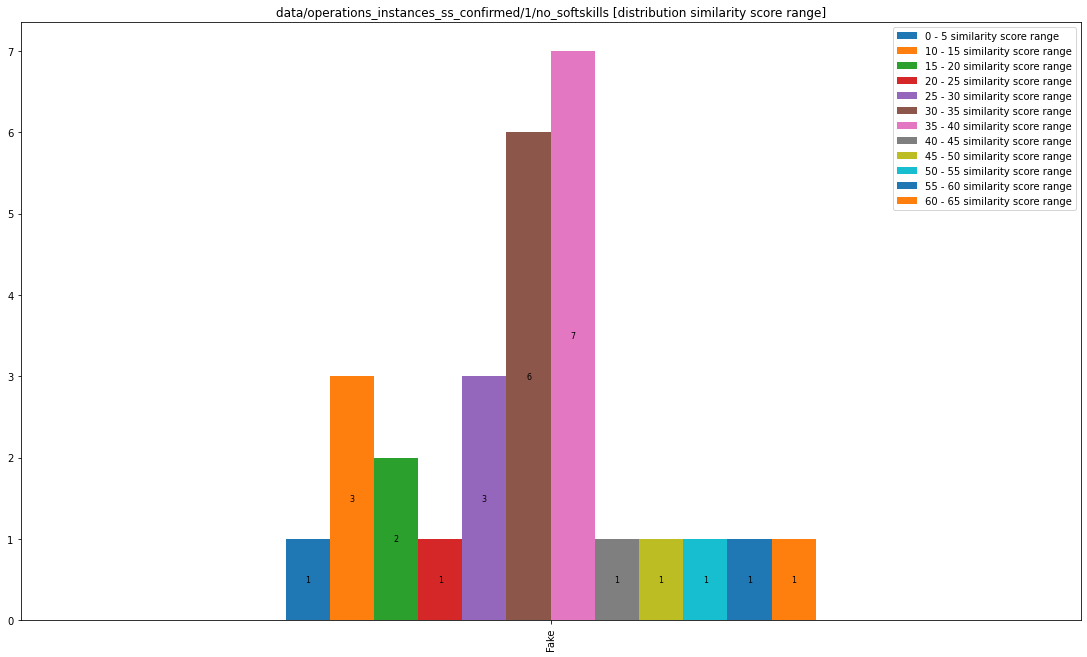

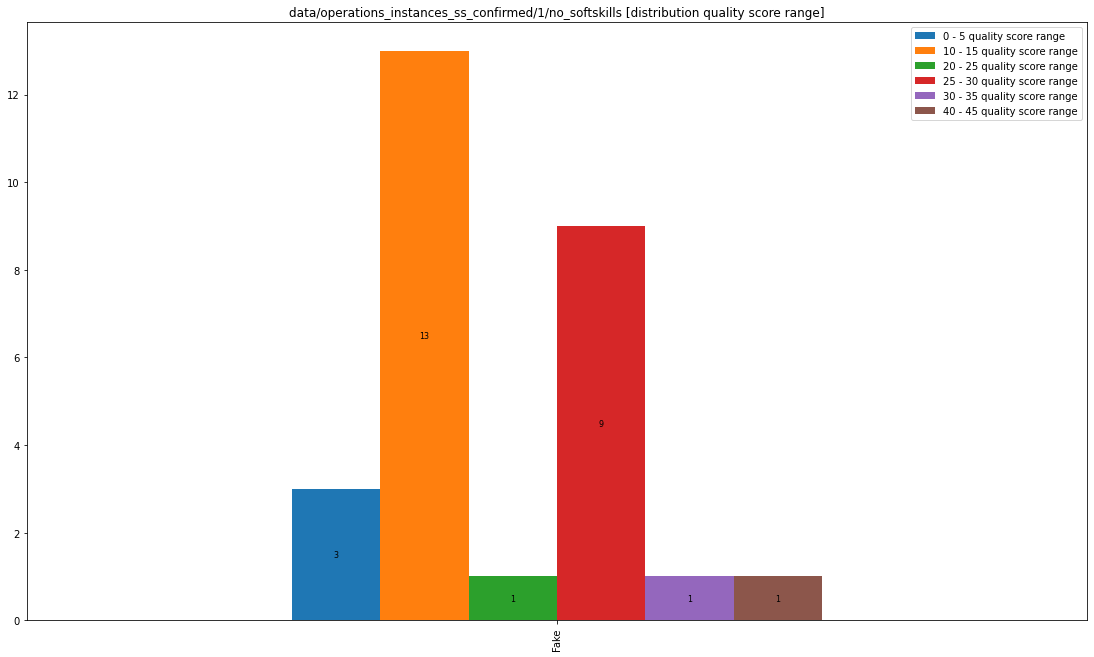

## OperationFile(layer='no_softskills_norm', test_subpath='1/no_softskills_norm', full_path='data/operations_instances_ss_confirmed/1/no_softskills_norm') - matches metrics

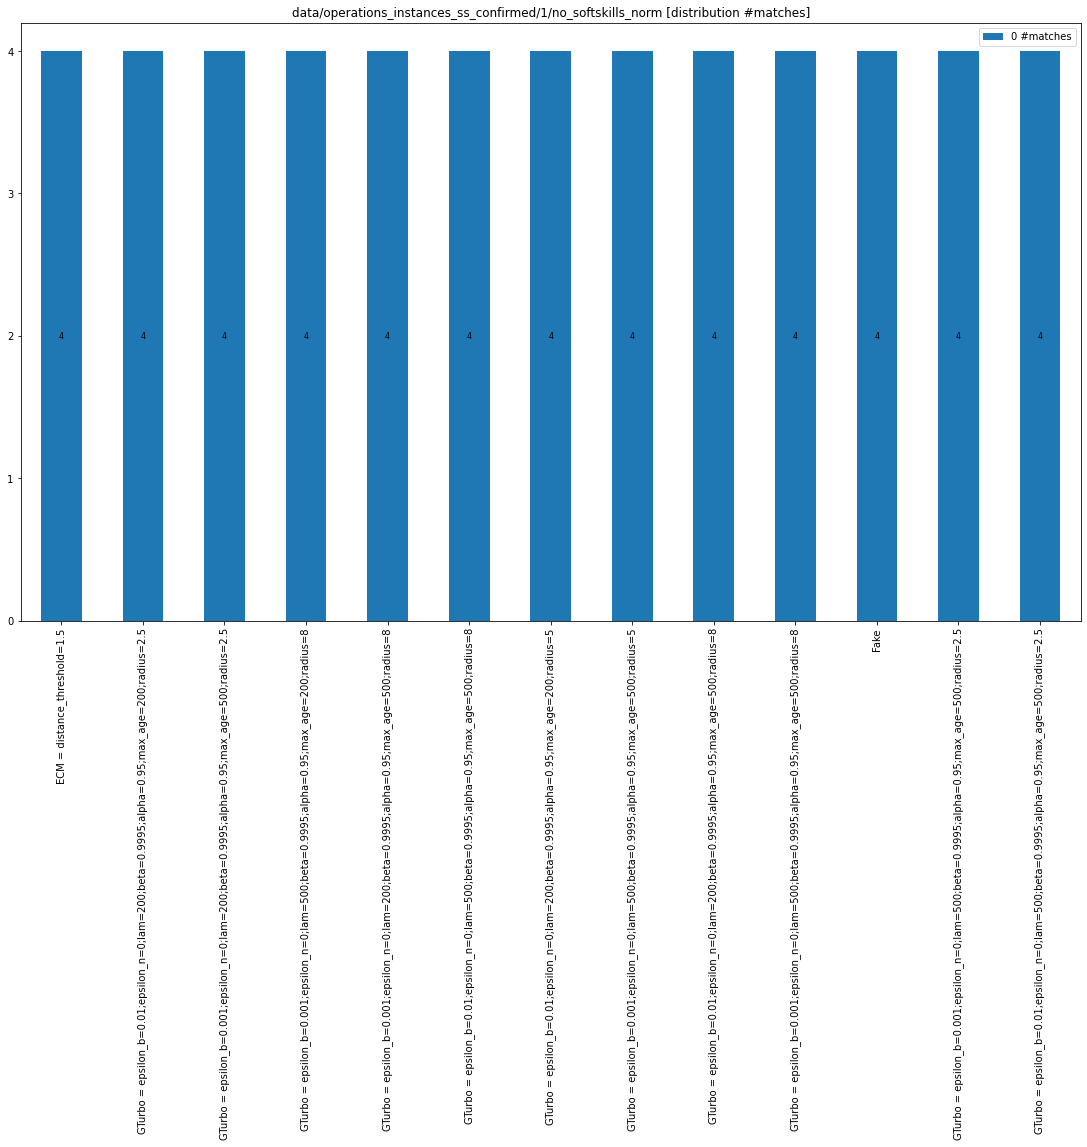

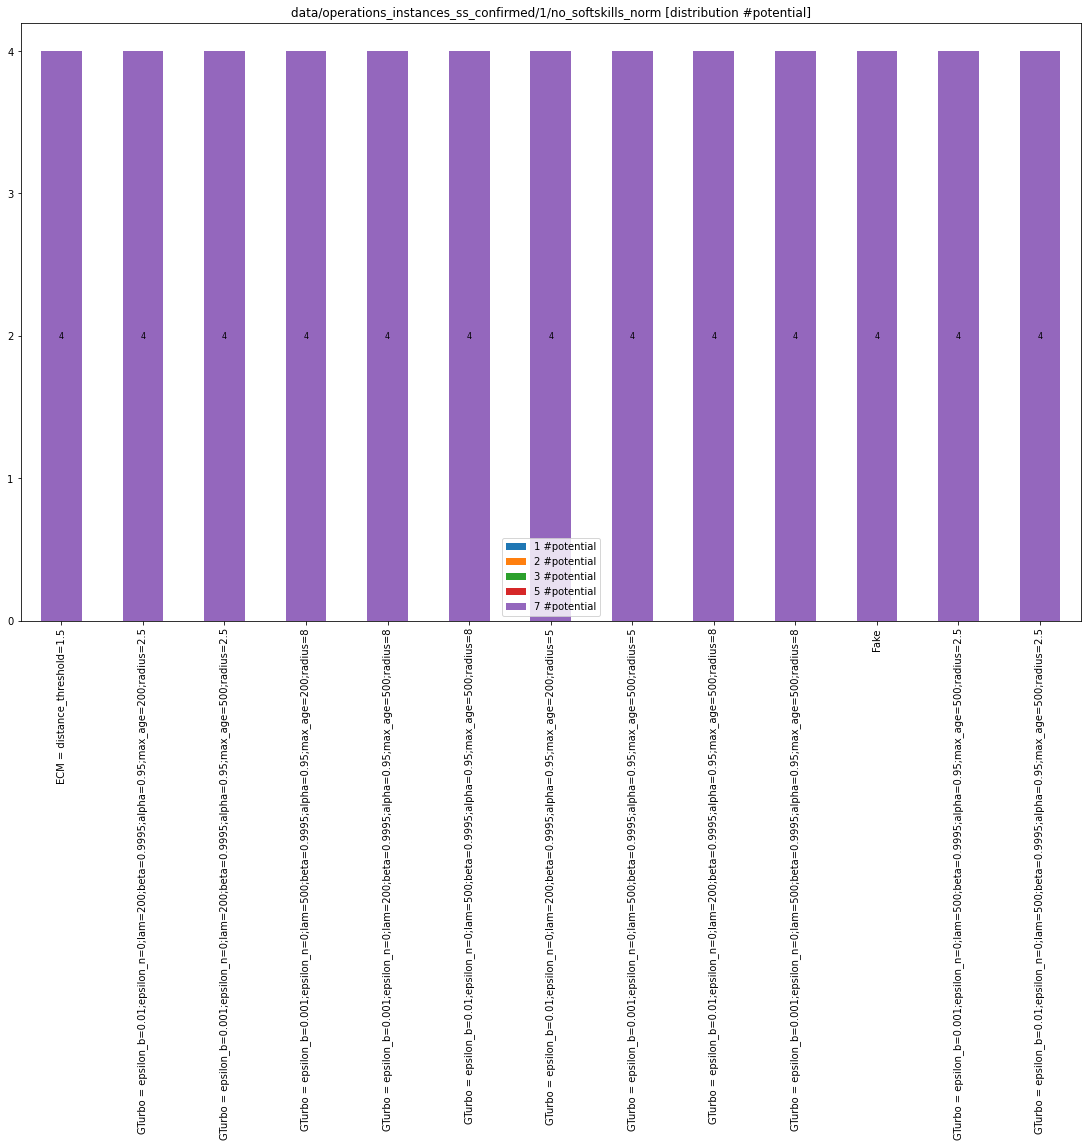

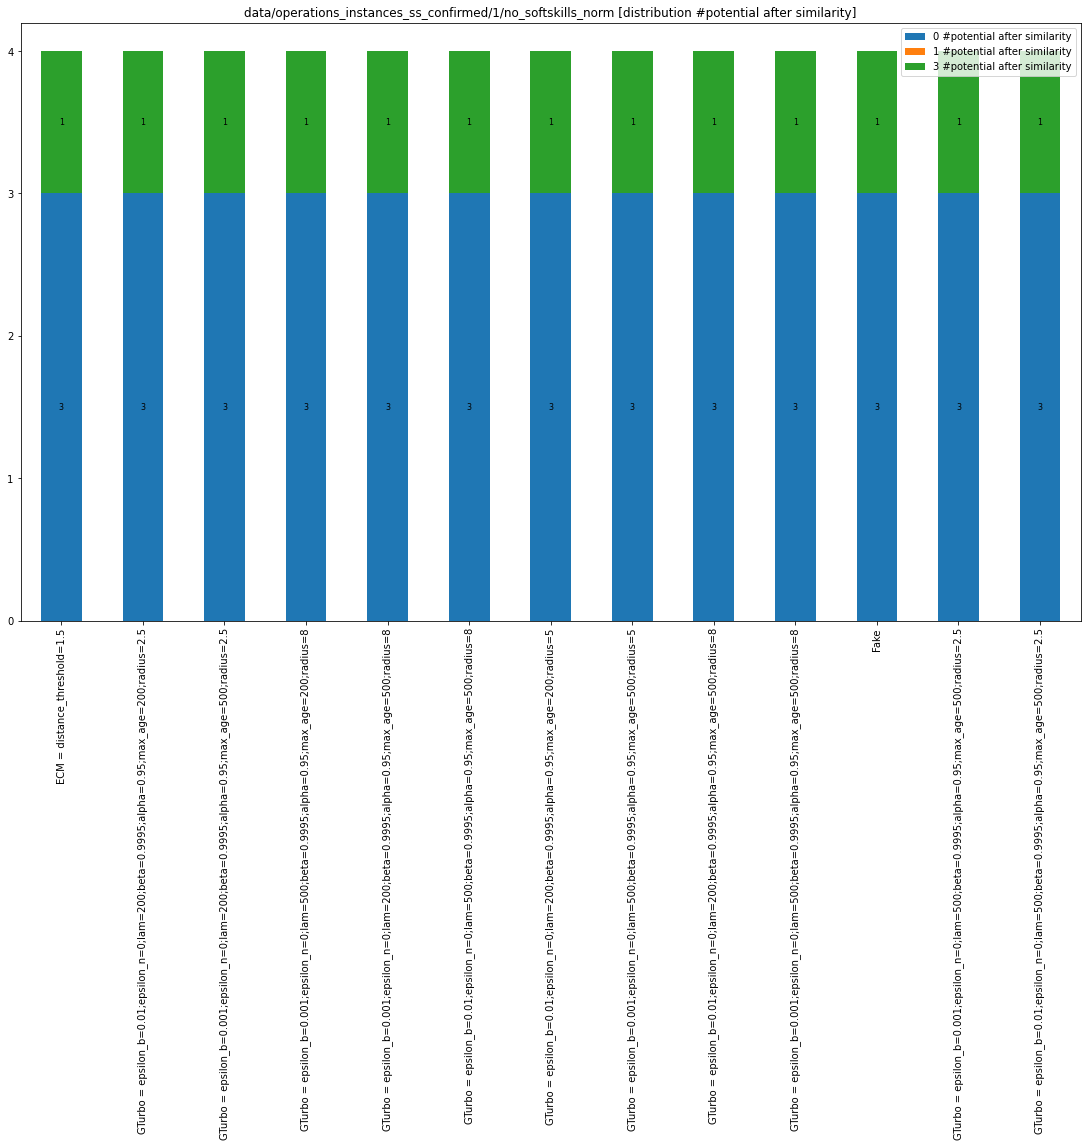

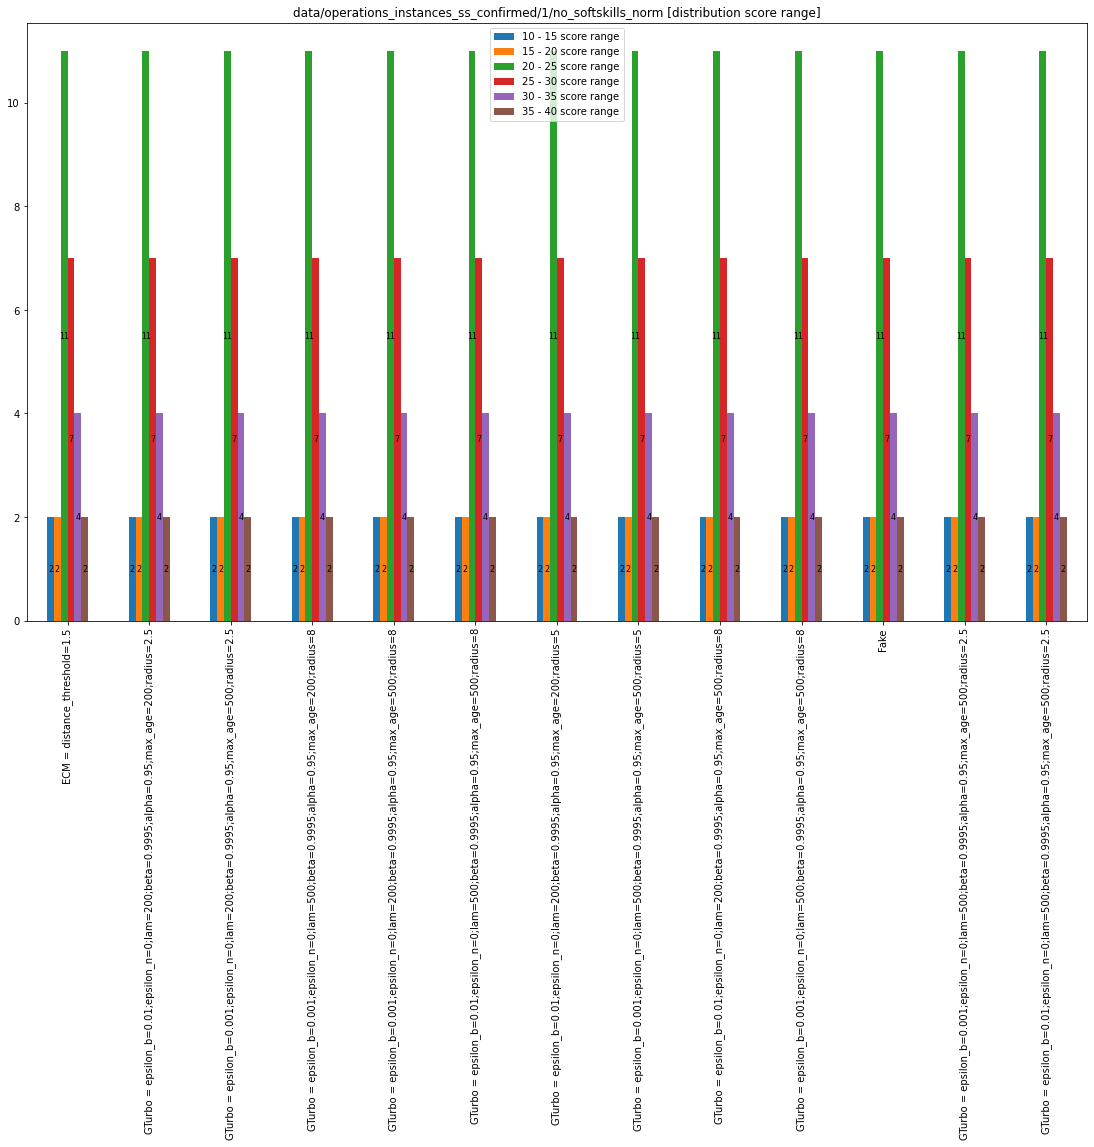

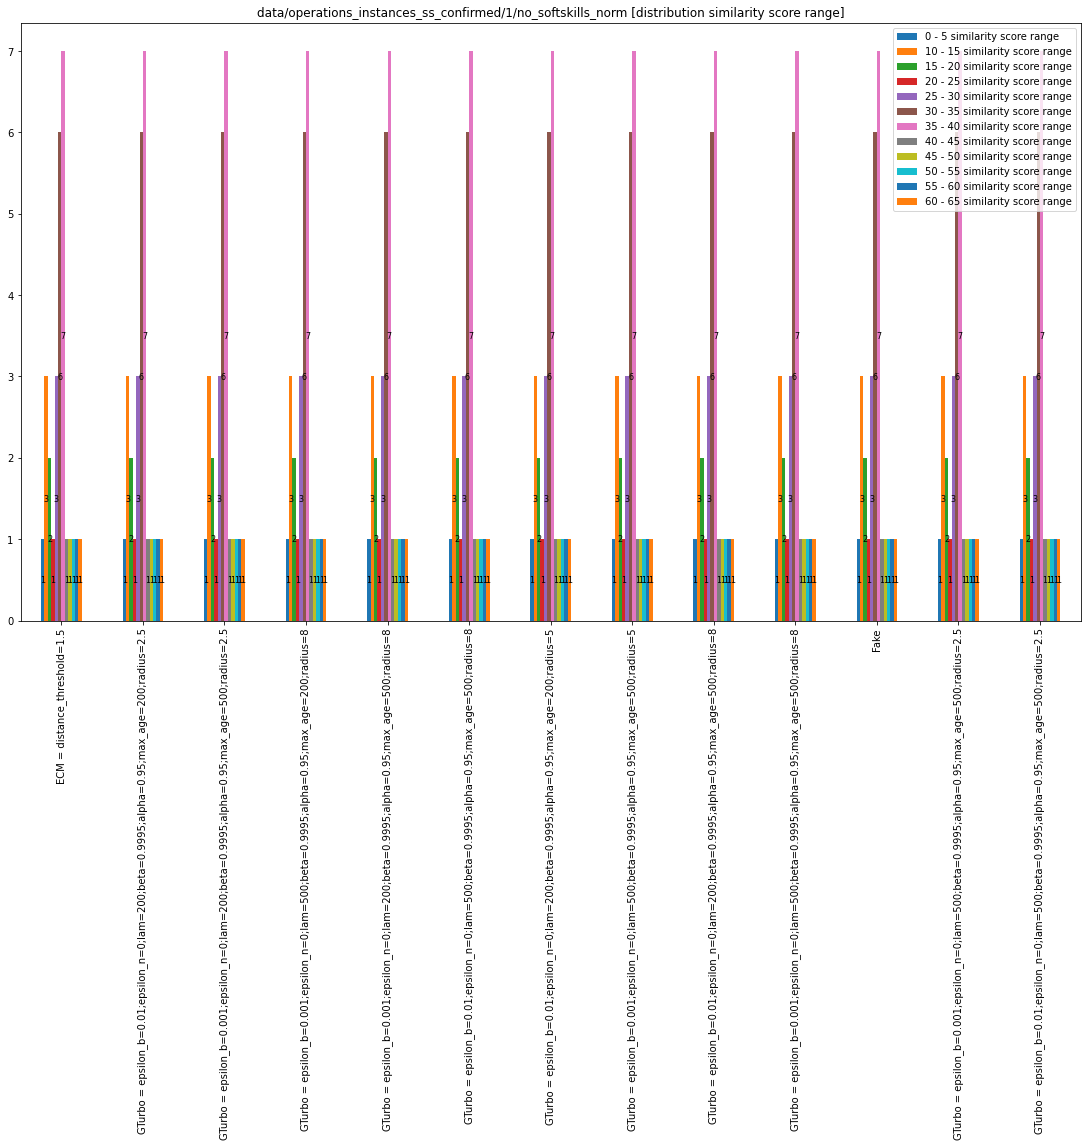

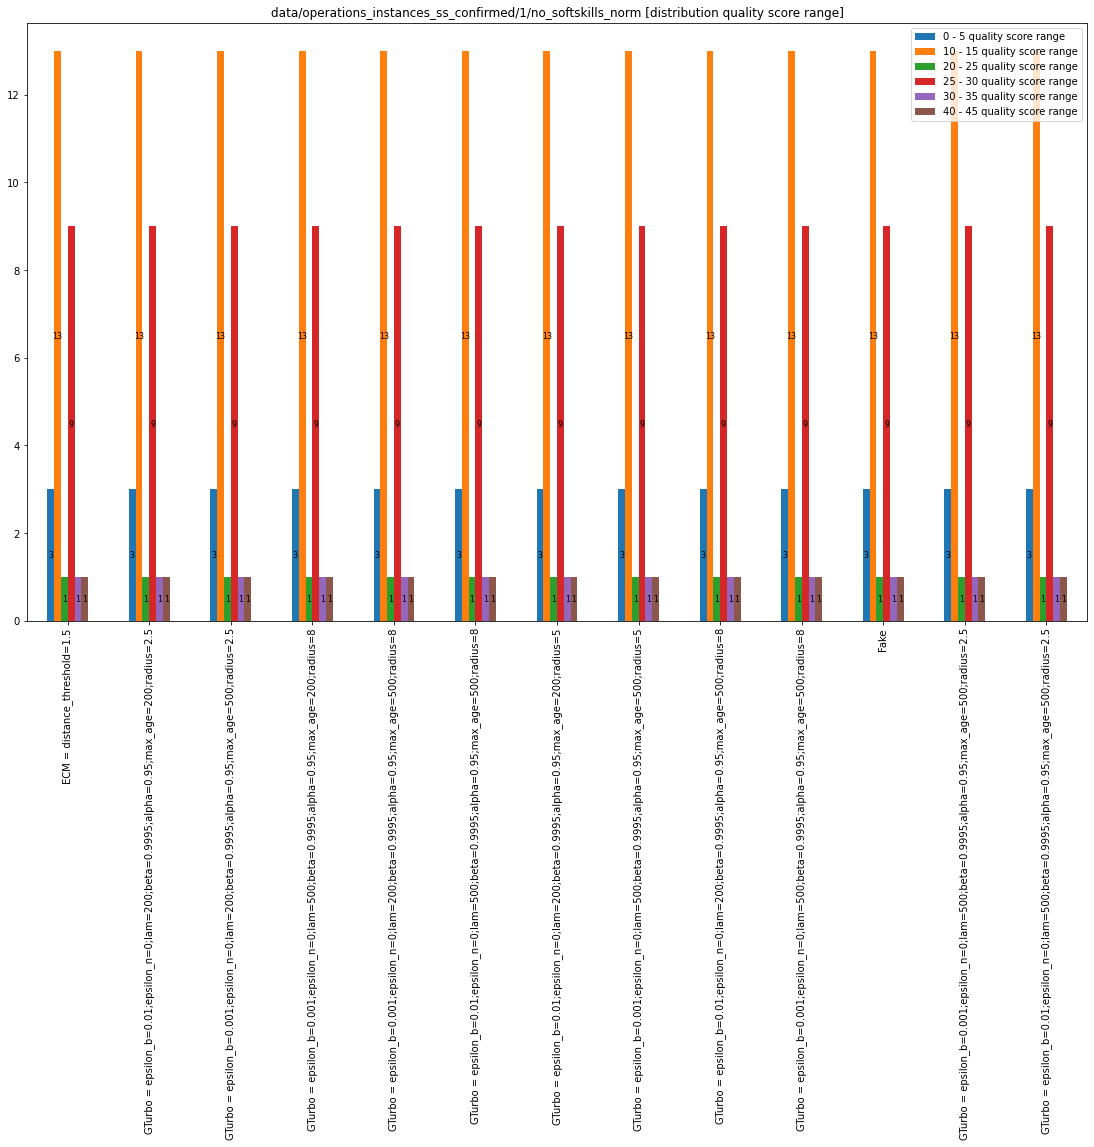

In [50]:

from interference.evaluation.match import bin_deviation_score

operations_file_to_good_by_cluster_metrics_and_bin: Dict[str, Dict[str, None]] = {}

for operations_file in operations_files:

    display(Markdown(f'## {operations_file} - matches metrics'))

    operations_file_to_good_by_cluster_metrics_and_bin[operations_file.full_path] = {}

    good_by_cluster_metrics = operations_file_to_good_by_cluster_metrics[operations_file.full_path]

    name_to_matches_metrics = operations_file_to_name_to_matches_metrics[operations_file.full_path]

    distribution_fake_matches_score_range = name_to_matches_metrics["Fake"]["distribution matches score range"]

    if len(distribution_fake_matches_score_range) != 0:
        bin_deviation_scores = []
        bin_deviation_scores_df = pd.DataFrame(index=list(good_by_cluster_metrics))
        
        for clusterer in name_to_matches_metrics:
            other_distribution_matches_score_range = name_to_matches_metrics[clusterer]["distribution matches score range"]
            bin_dev_score = bin_deviation_score(other_distribution_matches_score_range, distribution_fake_matches_score_range)

            if clusterer in good_by_cluster_metrics:
                bin_deviation_scores.append(bin_dev_score)
            
            operations_file_to_name_to_matches_metrics[operations_file.full_path][clusterer]["bin deviation score"] = bin_dev_score

        bin_deviation_scores_df["bin deviation score"] = bin_deviation_scores

        n = 5
        bin_deviation_scores_series = bin_deviation_scores_df["bin deviation score"].sort_values(ascending=False).head(n)

        if "Fake" not in bin_deviation_scores_series.index:
            bin_deviation_scores_series = bin_deviation_scores_series.append(pd.Series([bin_deviation_scores_df["bin deviation score"]["Fake"]], index=["Fake"]))

        plot = bin_deviation_scores_df.plot(kind='bar', figsize=(19,11))
        plot.set_title(f"{operations_file.full_path} [bin deviation score]")
        plt.show()

        for name in bin_deviation_scores_series.index:
            operations_file_to_good_by_cluster_metrics_and_bin[operations_file.full_path][name] = None

    else:
        operations_file_to_good_by_cluster_metrics_and_bin[operations_file.full_path] = good_by_cluster_metrics

    good_by_cluster_and_bin = operations_file_to_good_by_cluster_metrics_and_bin[operations_file.full_path]

    matches_metric_df = pd.DataFrame(index=list(good_by_cluster_and_bin.keys()))

    for matches_metric in matches_metrics:
        if matches_metric.find("distribution") != -1:
            fake_metric_distribution = name_to_matches_metrics["Fake"][matches_metric]

            for _range in fake_metric_distribution:
                matches_metric_df[matches_metric.replace("distribution", _range)] = [
                    name_to_matches_metrics[name][matches_metric][_range]
                    for name in good_by_cluster_and_bin
                ]
        else:
            matches_metric_df[matches_metric] = [
                name_to_matches_metrics[name][matches_metric]
                for name in good_by_cluster_and_bin
            ]

    for matches_metric in matches_metrics:
        if matches_metric.find("distribution") != -1:
            fake_metric_distribution: Dict[str, int] = name_to_matches_metrics["Fake"][matches_metric]

            if len(fake_metric_distribution) == 0:
                continue

            names = [matches_metric.replace("distribution", _range) for _range in fake_metric_distribution]

            z = matches_metric_df[names]

            v = [
                matches_metric_df[name]["Fake"]
                for name in names
            ]

            df = pd.DataFrame([v], columns = names, index=["Fake"])

            if "Fake" not in z.index:
                z = z.append(df)

            should_stack = matches_metric.find("#") != -1

            plot = z.plot(kind='bar', figsize=(19,11), stacked=should_stack)
            plot.set_title(f"{operations_file.full_path} [{matches_metric}]")

            plot.yaxis.set_major_locator(MaxNLocator(integer=True))
            for rect in plot.patches:
                # Find where everything is located
                height = rect.get_height()
                width = rect.get_width()
                x = rect.get_x()
                y = rect.get_y()
                
                # The height of the bar is the data value and can be used as the label
                label_text = f'{int(height)}'  # f'{height:.2f}' to format decimal values
                
                # ax.text(x, y, text)
                label_x = x + width / 2
                label_y = y + height / 2

                # plot only when height is greater than specified value
                if height > 0:
                    plot.text(label_x, label_y, label_text, ha='center', va='center', fontsize=8)

            plt.show()
        else:

            z = matches_metric_df[matches_metric]
            z = z.sort_values(ascending=False).head(n)

            if "Fake" not in z.index:
                z = z.append(pd.Series([matches_metric_df[matches_metric]["Fake"]], index=["Fake"]))

            plot = z.plot(kind='bar', figsize=(19,11))
            plot.set_title(f"{operations_file.full_path} [{matches_metric}]")
            plt.show()


## Overall

ss  \
file                                                        clusterer                                                                                         
data/operations_instances_ss_confirmed/1/concat_norm        ECM = distance_threshold=1.5                                                               -1.0   
                                                            GTurbo = epsilon_b=0.01;epsilon_n=0;lam=200;beta=0.9995;alpha=0.95;max_age=200;radius=2.5  -1.0   
                                                            GTurbo = epsilon_b=0.001;epsilon_n=0;lam=200;beta=0.9995;alpha=0.95;max_age=500;radius=2.5 -1.0   
                                                            GTurbo = epsilon_b=0.001;epsilon_n=0;lam=500;beta=0.9995;alpha=0.95;max_age=200;radius=8   -1.0   
                                                            GTurbo = epsilon_b=0.001;epsilon_n=0;lam=200;beta=0.9995;alpha=0.95;max_age=500;radius=8   -1.0   
                                                            GTurbo = epsilon_b=0.01;epsilon_n=0;lam=500;beta=0.9995;alpha=0.95;max_age=500;radius=8    -1.0   
                                                            GTurbo = epsilon_b=0.01;epsilon_n=0;lam=200;beta=0.9995;alpha=0.95;max_age=200;radius=5    -1.0   
                                                            GTurbo = epsilon_b=0.001;epsilon_n=0;lam=500;beta=0.9995;alpha=0.95;max_age=500;radius=5   -1.0   
                                                            GTurbo = epsilon_b=0.01;epsilon_n=0;lam=200;beta=0.9995;alpha=0.95;max_age=500;radius=8    -1.0   
                                                            GTurbo = epsilon_b=0.001;epsilon_n=0;lam=500;beta=0.9995;alpha=0.95;max_age=500;radius=8   -1.0   
                                                            Fake                                                                                       -1.0   
                                                            GTurbo = epsilon_b=0.001;epsilon_n=0;lam=500;beta=0.9995;alpha=0.95;max_age=500;radius=2.5 -1.0   
data/operations_instances_ss_confirmed/1/concat             Fake                                                                                       -1.0   
data/operations_instances_ss_confirmed/1/avg                Fake                                                                                       -1.0   
                                                            CovCluster = initial_std=10                                                                -1.0   
data/operations_instances_ss_confirmed/1/avg_norm           ECM = distance_threshold=1.5                                                               -1.0   
                                                            GTurbo = epsilon_b=0.01;epsilon_n=0;lam=200;beta=0.9995;alpha=0.95;max_age=200;radius=2.5  -1.0   
                                                            GTurbo = epsilon_b=0.001;epsilon_n=0;lam=200;beta=0.9995;alpha=0.95;max_age=500;radius=2.5 -1.0   
                                                            GTurbo = epsilon_b=0.001;epsilon_n=0;lam=500;beta=0.9995;alpha=0.95;max_age=200;radius=8   -1.0   
                                                            GTurbo = epsilon_b=0.001;epsilon_n=0;lam=200;beta=0.9995;alpha=0.95;max_age=500;radius=8   -1.0   
                                                            Fake                                                                                       -1.0   
data/operations_instances_ss_confirmed/1/no_softskills      Fake                                                                                       -1.0   
data/operations_instances_ss_confirmed/1/no_softskills_norm ECM = distance_threshold=1.5                                                               -1.0   
                                                            GTurbo = epsilon_b=0.01;epsilon_n=0;lam=200;beta=0.9995;alpha=0.95;max_age=200;radius=2.5  -1.0   
                   

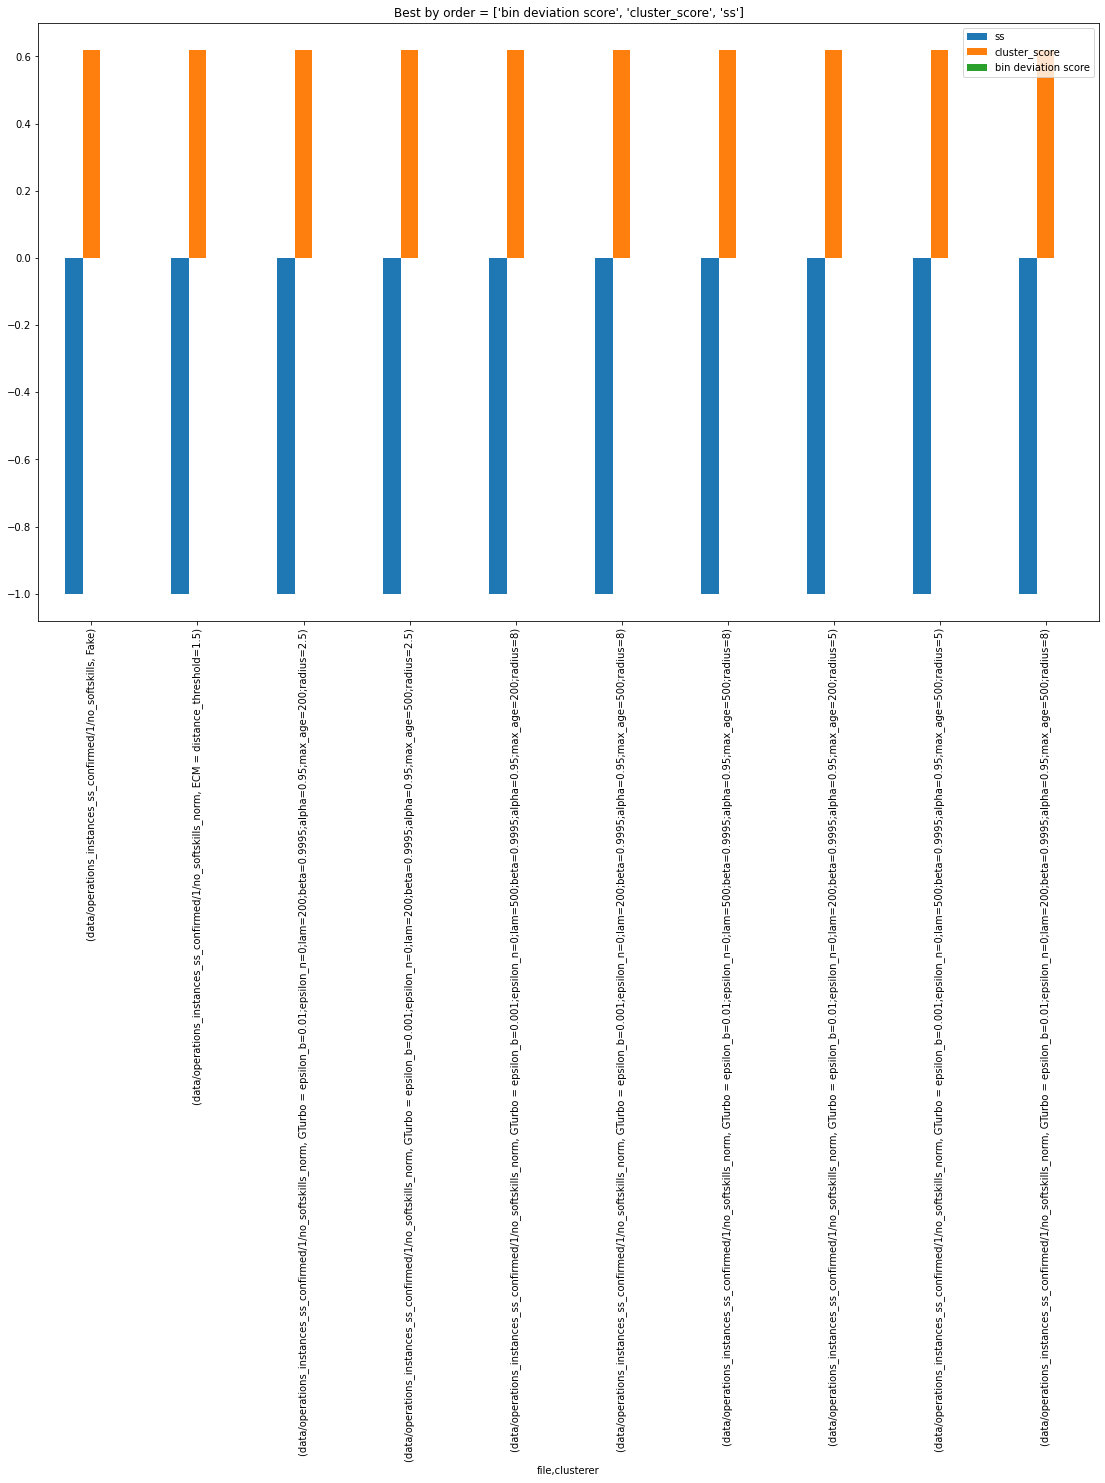

In [51]:
ss_scores = []
cluster_scores = []
bdss = []
files = []
clusterers = []

for operations_file in operations_file_to_good_by_cluster_metrics_and_bin:
    for clusterer in operations_file_to_good_by_cluster_metrics_and_bin[operations_file]:
        files.append(operations_file)
        clusterers.append(clusterer)
        ss_scores.append(operations_file_to_name_to_cluster_metrics[operations_file][clusterer]["ss"])
        cluster_scores.append(operations_file_to_name_to_cluster_metrics[operations_file][clusterer]["cluster_score"])
        bdss.append(operations_file_to_name_to_matches_metrics[operations_file][clusterer].get("bin deviation score", 0))

mui = pd.MultiIndex.from_arrays([files, clusterers], names=["file", "clusterer"])

best_of_the_best_df = pd.DataFrame(
    data = { "ss": ss_scores, "cluster_score" : cluster_scores, "bin deviation score" : bdss },
    index = mui,
)

display(best_of_the_best_df)

order = ["bin deviation score", "cluster_score", "ss"]

ordered = best_of_the_best_df.sort_values(by=order, ascending=False)

plot = ordered.head(10).plot(kind='bar', figsize=(19,11))
plot.set_title(f"Best by order = {order}")
plt.show()